In [1]:
from qnet_context import qnetvo as qnet
from mac_context import *
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [145]:
def ea_prep_state(settings, wires):
    for i in range(4):
        qml.PauliX(wires=[wires[i]])

    for i in range(2):
        qml.Hadamard(wires=[wires[i]])
        qml.CNOT(wires=[wires[i],wires[i+2]])
        
def rzry_meas_state(settings, wires):
    qml.RZ(settings[0], wires=wires[0])
    qml.RZ(settings[1], wires=wires[1])
    
    qml.RY(settings[2], wires=wires[0])
    qml.RY(settings[3], wires=wires[1])
    qml.RZ(settings[4], wires=wires[0])
    qml.RZ(settings[5], wires=wires[1])
    qml.CNOT(wires=wires[0:2])
    qml.Hadamard(wires=wires[0])



def rot_meas_state(settings, wires):
    qml.CNOT(wires=[wires[1],wires[0]])
    qml.Rot(*settings[0:3], wires=wires[0])
    qml.Rot(*settings[3:6], wires=wires[1])
    qml.CNOT(wires=wires[0:2])
    qml.Hadamard(wires=wires[0])

    

    

ea_prep_node = [
    qnet.PrepareNode(1, [0,1,2,3], ea_prep_state, 0)
]
cl_prep_node = [
    qnet.PrepareNode(1, [0,1,2,3], lambda settings, wires: None, 0)
]
ry_meas_nodes = [
    qnet.MeasureNode(3, 2, [0,1], qnet.local_RY, 2),
    qnet.MeasureNode(3, 2, [2,3], qnet.local_RY, 2)
]
rzry_meas_nodes = [
    qnet.MeasureNode(3, 2, [0,1], rzry_meas_state, 6),
    qnet.MeasureNode(3, 2, [2,3], rzry_meas_state, 6)
]
rot_meas_nodes = [
    qnet.MeasureNode(3, 2, [0,1], rot_meas_state, 6),
    qnet.MeasureNode(3, 2, [2,3], rot_meas_state, 6)
]
arb_meas_nodes = [
    qnet.MeasureNode(3, 2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15),
    qnet.MeasureNode(3, 2, [2,3], qml.templates.subroutines.ArbitraryUnitary, 15)
]



ea_ansatz = qnet.NetworkAnsatz(ea_prep_node, rot_meas_nodes)
cl_ansatz = qnet.NetworkAnsatz(cl_prep_node, ry_meas_nodes)

# uniform prior distribution
uniform3 = np.ones(3)/3

In [89]:
def mutual_info_magic_squares_cost_fn(ansatz, priors):
    
    probs_qnode = qnet.joint_probs_qnode(ansatz)
    
    def cost_fn(ansatz_settings):
        # optimize winning probability
        P_Z_list = []
        
        for x in range(3):
            for y in range(3):
                
                settings = ansatz.qnode_settings(ansatz_settings, [0], [x, y]) # prep node is static
                probs_xy = probs_qnode(settings)
                                
                prior_xy = priors[0][x] * priors[1][y]
                
                P_win_xy = 0

                for z in range(16):
                    bit_string = [int(j) for j in np.binary_repr(z,4)]

                    A_parity_bit = 0 if (bit_string[0] + bit_string[1]) % 2 == 0 else 1
                    B_parity_bit = 1 if (bit_string[2] + bit_string[3]) % 2 == 0 else 0

                    A_bits = bit_string[0:2] + [A_parity_bit]
                    B_bits = bit_string[2:] + [B_parity_bit]

                    if A_bits[y] == B_bits[x]:
                        P_win_xy += probs_xy[z] * prior_xy
                                                          
                P_Z_list.append(P_win_xy)
        
        # postprocess winning probablity into mutual information
        P_lose = 1 - np.sum(P_Z_list)
        
        P_Z = P_lose * np.ones(9)/9 + np.array(P_Z_list)
                
        H_Z = qnet.shannon_entropy(P_Z)
                
        mutual_info = H_Z - P_lose * np.log2(9)
                        
        return -(mutual_info)
    
    return cost_fn

In [90]:
ea_cost = mutual_info_magic_squares_cost_fn(ea_ansatz, [uniform3, uniform3])

ea_opt_dict = qnet.gradient_descent(
    ea_cost,
    ea_ansatz.rand_scenario_settings(),
    num_steps=150,
    step_size=1,
    sample_width=5
)

iteration :  0 , score :  1.742539015292909
elapsed time :  0.1160430908203125
iteration :  5 , score :  2.117900300767272
elapsed time :  0.11458492279052734
iteration :  10 , score :  2.4663251791428995
elapsed time :  0.11588597297668457
iteration :  15 , score :  2.8715970195948963
elapsed time :  0.11578798294067383
iteration :  20 , score :  3.055871867485642
elapsed time :  0.23795676231384277
iteration :  25 , score :  3.1242567009488424
elapsed time :  0.23323488235473633
iteration :  30 , score :  3.149792424670883
elapsed time :  0.11212420463562012
iteration :  35 , score :  3.1594630618486494
elapsed time :  0.1264958381652832
iteration :  40 , score :  3.1633427600382893
elapsed time :  0.11400890350341797
iteration :  45 , score :  3.165226645222826
elapsed time :  0.11529898643493652
iteration :  50 , score :  3.1663423453320183
elapsed time :  0.11336803436279297
iteration :  55 , score :  3.1670924988300766
elapsed time :  0.11119794845581055
iteration :  60 , score :

In [92]:
def scan_magic_squares_rate_region(ansatz, prior_x1_samples, prior_x2_samples, **opt_kwargs):
    
    rate_tuples = []
    opt_dicts = []
    priors_list = []
    for prior_x1 in prior_x1_samples:
        for prior_x2 in prior_x2_samples:
            print("prior_x1  = ", prior_x1)
            print("prior_x2 = ", prior_x2)
            
            cost = mutual_info_magic_squares_cost_fn(ansatz, [prior_x1, prior_x2])

            opt_dict = qnet.gradient_descent(
                cost,
                ansatz.rand_scenario_settings(),
                **opt_kwargs
            )
            
            mac_behavior = mac_game_behavior_fn(ansatz)
                   
            P_mac, prior_mac = mac_behavior(
                opt_dict["opt_settings"],
                [prior_x1, prior_x2]
            )
            rate_tuple = mac_game_rate_tuple(P_mac, prior_mac)
            print(rate_tuple)
        
            opt_dicts.append(opt_dict)
            rate_tuples.append(rate_tuple)
            priors_list.append([prior_x1, prior_x2])
                  
    return rate_tuples, opt_dicts, priors_list

In [102]:
def mac_game_behavior_fn(ansatz):
    """Constructs and ansatz-specific behavior function.
    
    The the function is called as `behavior(ansatz_settings, [prior_x1, prior_x2])`
    with `prior_x1` and `prior_x2` being prior distibutions P(x1) and P(x2).
    
    The constructed behavior has form P(z|x1,x2,y1,y2) with a joint prior distribution
    P(x1,x2,y1,y2) = P(x1)P(x2)P(y1,y2|x1,x2).
    """
        
    behavior = qnet.behavior_fn(ansatz)
    
    def behavior_fn(settings, priors):
        
        raw_behavior = behavior(settings)
        
        prior_xy = np.kron(priors[0], priors[1])
        
        new_priors = (raw_behavior * prior_xy).T.reshape(144) 
                
        P_win = []
        P_mac_game = np.zeros((9,144))
        i = 0
        for x in range(3):
            for y in range(3):
                
                win_col_ids = []
                lose_col_ids = []
                for z in range(16):
                    bit_string = [int(j) for j in np.binary_repr(z,4)]

                    A_parity_bit = 0 if (bit_string[0] + bit_string[1]) % 2 == 0 else 1
                    B_parity_bit = 1 if (bit_string[2] + bit_string[3]) % 2 == 0 else 0

                    A_bits = bit_string[0:2] + [A_parity_bit]
                    B_bits = bit_string[2:] + [B_parity_bit]

                    if A_bits[y] == B_bits[x]:
                        win_col_ids.append(z)
                    else:
                        lose_col_ids.append(z)
                
                block_xy = np.zeros((9,16)) 
                block_xy[3*x + y, win_col_ids] = np.ones(len(win_col_ids))
                block_xy[:,lose_col_ids] = np.ones((9,len(lose_col_ids)))/9
            
                P_mac_game[:,16*i:16*(i + 1)] = block_xy
                
                i += 1
                
        return P_mac_game, new_priors
    
    return behavior_fn

In [139]:
def mac_game_rate_tuple(behavior, priors):
    """Evaluates the rate tuple (R1, R2, R1 + R2) for a given mac game
    behavior matrix with probabilities P(z|x1,x2,y1,y2) and priors P(x1,x2,y1,y2).
        
    Returns the rate tuple (R1, R2, R_sum) 
    """
    P_x1x2y1y2 = behavior * priors
    
    P_x1x2y1 = P_x1x2y1y2[:,0:144:4] + P_x1x2y1y2[:,1:144:4] + P_x1x2y1y2[:,2:144:4] + P_x1x2y1y2[:,3:144:4]
    priors_x1x2y1 = priors[0:144:4] + priors[1:144:4] + priors[2:144:4] + priors[3:144:4]
    
#     y1_ids = []
    y1_ids = np.array([[i,i+1,i+2,i+3] for i in range(0,144,16)]).flatten()
#     y1_ids = np.array([0,1,4,5,8,9,12,13,16,17,20,21,24,25,28,29,32,33])
    P_x1x2y2 = P_x1x2y1y2[:, y1_ids] + P_x1x2y1y2[:,y1_ids+4] + P_x1x2y1y2[:,y1_ids+8] + P_x1x2y1y2[:,y1_ids+12]
    priors_x1x2y2 = priors[y1_ids] + priors[y1_ids+4] + priors[y1_ids+8] + priors[y1_ids+12]
    
#     x2_ids = []
    x2_ids = np.array([[i,i+1,i+2,i+3] for i in range(0,36,12)]).flatten()
#     x2_ids = np.array([0,1,6,7,12,13])
    P_x1y1 = P_x1x2y1[:,x2_ids] + P_x1x2y1[:,x2_ids + 4] + P_x1x2y1[:,x2_ids + 8]
    priors_x1y1 = priors_x1x2y1[x2_ids] + priors_x1x2y1[x2_ids + 4] + priors_x1x2y1[x2_ids + 8]
    
    
#     x1_ids = []
    x1_ids = np.array([i for i in range(12)])
#     x1_ids = np.array([0,1,2,3,4,5])
    P_x2y2 = P_x1x2y2[:,x1_ids] + P_x1x2y2[:,x1_ids + 12] + P_x1x2y2[:,x1_ids + 24]
    priors_x2y2 = priors_x1x2y2[x1_ids] + priors_x1x2y2[x1_ids + 12] + priors_x1x2y2[x1_ids + 24]
    
    H_in = qnet.shannon_entropy(priors)
    H_joint = qnet.shannon_entropy((P_x1x2y1y2).T.reshape(9*144))
    H_z = qnet.shannon_entropy([np.sum(row) for row in (P_x1x2y1y2)])

    mutual_info = H_in + H_z - H_joint
    
    H_x1y1 = qnet.shannon_entropy(priors_x1y1)
    H_x2y2 = qnet.shannon_entropy(priors_x2y2)
    H_zx1y1 = qnet.shannon_entropy((P_x1y1).T.reshape(9*4*3))
    H_zx2y2 = qnet.shannon_entropy((P_x2y2).T.reshape(9*4*3))
    
    mutual_info_z_x1y1 = H_z + H_x1y1 - H_zx1y1
    mutual_info_z_x2y2 = H_z + H_x2y2 - H_zx2y2
        
    return (mutual_info - mutual_info_z_x2y2, mutual_info - mutual_info_z_x1y1 , mutual_info)

In [169]:
cl_rate_tuples = []
cl_opt_dicts = []
cl_priors_list = []

In [178]:
%%time

scan_range3 = np.unique([
    np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(3)
], axis=0)


cl_rate_tuples3, cl_opt_dicts3, cl_priors_list3 = scan_magic_squares_rate_region(
    cl_ansatz,
    scan_range3,
    scan_range3,
    num_steps=50,
    step_size=1.5,
    sample_width=5,
    verbose=True
)

cl_rate_tuples.extend(cl_rate_tuples3)
cl_opt_dicts.extend(cl_opt_dicts3)
cl_priors_list.extend(cl_priors_list3)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  0.7116388352472729
elapsed time :  0.057617902755737305
iteration :  5 , score :  0.7408217191521431
elapsed time :  0.04794788360595703
iteration :  10 , score :  0.7438836459404796
elapsed time :  0.0445408821105957
iteration :  15 , score :  0.7444750612395152
elapsed time :  0.04654097557067871
iteration :  20 , score :  0.7445123219798071
elapsed time :  0.05765390396118164
iteration :  25 , score :  0.7445137105924224
elapsed time :  0.04346203804016113
iteration :  30 , score :  0.7445137561777087
elapsed time :  0.0434870719909668
iteration :  35 , score :  0.7445137576384049
elapsed time :  0.04517316818237305
iteration :  40 , score :  0.7445137576850058
elapsed time :  0.045607805252075195
iteration :  45 , score :  0.7445137576864909
elapsed time :  0.04715895652770996
(0.6736244315861688, 0.7100425345200723, 0.7445137576865384)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.    0.333 0.667]
iteration :  0 , s

iteration :  40 , score :  2.777312635017715
elapsed time :  0.04839825630187988
iteration :  45 , score :  2.7773493816466264
elapsed time :  0.04530501365661621
(1.6065106557358133, 1.4662245353178087, 2.7801549296810193)
CPU times: user 25.7 s, sys: 528 ms, total: 26.2 s
Wall time: 26.2 s


In [171]:
%%time

scan_range12 = np.unique([
    np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(12)
], axis=0)

# scan_range3 = [
#     np.around(prior,decimals=3) for prior in priors_scan_range(3)
# ]

cl_rate_tuples12, cl_opt_dicts12, cl_priors_list12 = scan_magic_squares_rate_region(
    cl_ansatz,
    scan_range12,
    scan_range12,
    num_steps=50,
    step_size=1.5,
    sample_width=5,
    verbose=True
)

cl_rate_tuples.extend(cl_rate_tuples12)
cl_opt_dicts.extend(cl_opt_dicts12)
cl_priors_list.extend(cl_priors_list12)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  0.7401814273663834
elapsed time :  0.0684957504272461
iteration :  5 , score :  0.7406241974693935
elapsed time :  0.06692624092102051
iteration :  10 , score :  0.7413138247853046
elapsed time :  0.07553791999816895
iteration :  15 , score :  0.7422831720258829
elapsed time :  0.06696701049804688
iteration :  20 , score :  0.7433478703761511
elapsed time :  0.19145965576171875
iteration :  25 , score :  0.7441067934877719
elapsed time :  0.0746908187866211
iteration :  30 , score :  0.7444189062940156
elapsed time :  0.07518410682678223
iteration :  35 , score :  0.744497016810969
elapsed time :  0.06813907623291016
iteration :  40 , score :  0.7445111943037845
elapsed time :  0.06692194938659668
iteration :  45 , score :  0.7445133883440915
elapsed time :  0.0708003044128418
(0.6046352894245492, 0.7286677529577053, 0.7445137057301014)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.    0.083 0.917]
iteration :  0 , score

iteration :  45 , score :  1.3675327089643345
elapsed time :  0.07088708877563477
(1.1020757142432558e-06, 1.367532791614389, 1.3675328092560322)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.083 0.25  0.667]
iteration :  0 , score :  1.011442880467248
elapsed time :  0.07102084159851074
iteration :  5 , score :  1.278403167588811
elapsed time :  0.06756377220153809
iteration :  10 , score :  1.374723951845008
elapsed time :  0.06843304634094238
iteration :  15 , score :  1.4231082629421974
elapsed time :  0.07324385643005371
iteration :  20 , score :  1.4471325639730117
elapsed time :  0.07230591773986816
iteration :  25 , score :  1.4545839531105231
elapsed time :  0.0684199333190918
iteration :  30 , score :  1.4564950244189898
elapsed time :  0.07009196281433105
iteration :  35 , score :  1.4569605931720186
elapsed time :  0.07196998596191406
iteration :  40 , score :  1.4570726242126055
elapsed time :  0.07069802284240723
iteration :  45 , score :  1.4570995122095807
elapsed time :  0.06

iteration :  35 , score :  1.6795984821552392
elapsed time :  0.06924605369567871
iteration :  40 , score :  1.6798381358303673
elapsed time :  0.06729483604431152
iteration :  45 , score :  1.67996209010807
elapsed time :  0.06753420829772949
(0.12574124376021212, 1.649362006615306, 1.680026862315151)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.333 0.333 0.333]
iteration :  0 , score :  1.2761929223306892
elapsed time :  0.07097792625427246
iteration :  5 , score :  1.4399634750202501
elapsed time :  0.07611918449401855
iteration :  10 , score :  1.6172241302642818
elapsed time :  0.07035088539123535
iteration :  15 , score :  1.6823895587233668
elapsed time :  0.07741022109985352
iteration :  20 , score :  1.6843292308724662
elapsed time :  0.06704282760620117
iteration :  25 , score :  1.6851902779049874
elapsed time :  0.07740497589111328
iteration :  30 , score :  1.6859003326878017
elapsed time :  0.06661295890808105
iteration :  35 , score :  1.6865094209482352
elapsed time :  0.0794

iteration :  20 , score :  1.4206391372054648
elapsed time :  0.07689976692199707
iteration :  25 , score :  1.427546825400161
elapsed time :  0.08225107192993164
iteration :  30 , score :  1.429282579906393
elapsed time :  0.07348990440368652
iteration :  35 , score :  1.4297143765050668
elapsed time :  0.06660103797912598
iteration :  40 , score :  1.429823320822673
elapsed time :  0.20223784446716309
iteration :  45 , score :  1.4298513802064599
elapsed time :  0.06864190101623535
(0.35765579017377025, 1.1672109882666333, 1.4304362886997102)
prior_x1  =  [0.    0.083 0.917]
prior_x2 =  [0.083 0.167 0.75 ]
iteration :  0 , score :  1.1895538457706827
elapsed time :  0.072174072265625
iteration :  5 , score :  1.3759551855837775
elapsed time :  0.20542120933532715
iteration :  10 , score :  1.480118493178031
elapsed time :  0.06815314292907715
iteration :  15 , score :  1.5335801997183263
elapsed time :  0.07807493209838867
iteration :  20 , score :  1.5539279067961038
elapsed time : 

iteration :  5 , score :  1.602631358489553
elapsed time :  0.06563878059387207
iteration :  10 , score :  1.7966078387537894
elapsed time :  0.06815385818481445
iteration :  15 , score :  1.8409678310920978
elapsed time :  0.06728601455688477
iteration :  20 , score :  1.847964779003675
elapsed time :  0.06586122512817383
iteration :  25 , score :  1.8508527880345633
elapsed time :  0.0665280818939209
iteration :  30 , score :  1.8531303766591602
elapsed time :  0.06605005264282227
iteration :  35 , score :  1.8562750194949156
elapsed time :  0.07175111770629883
iteration :  40 , score :  1.8611802630257592
elapsed time :  0.06759905815124512
iteration :  45 , score :  1.8665154786568907
elapsed time :  0.06613612174987793
(0.40317673128454334, 1.5994159266729993, 1.8696953942481636)
prior_x1  =  [0.    0.083 0.917]
prior_x2 =  [0.25  0.333 0.417]
iteration :  0 , score :  1.3363013810032152
elapsed time :  0.06705284118652344
iteration :  5 , score :  1.8495503899242505
elapsed time 

(0.8613012666881534, 1.069697184468128, 1.7453863478485414)
prior_x1  =  [0.    0.167 0.833]
prior_x2 =  [0.  0.5 0.5]
iteration :  0 , score :  1.335903099658501
elapsed time :  0.07330894470214844
iteration :  5 , score :  1.4692794262195208
elapsed time :  0.06775903701782227
iteration :  10 , score :  1.5363009707142115
elapsed time :  0.06782221794128418
iteration :  15 , score :  1.551879218617412
elapsed time :  0.06679391860961914
iteration :  20 , score :  1.5553503712309888
elapsed time :  0.06727099418640137
iteration :  25 , score :  1.5586059009106936
elapsed time :  0.07044410705566406
iteration :  30 , score :  1.5628996582005974
elapsed time :  0.07192206382751465
iteration :  35 , score :  1.5690273009364035
elapsed time :  0.07366180419921875
iteration :  40 , score :  1.578286982043724
elapsed time :  0.07070684432983398
iteration :  45 , score :  1.5934606315096225
elapsed time :  0.06699109077453613
(0.6304339775879835, 1.1968630871000214, 1.6207966930247517)
prior

iteration :  35 , score :  2.015289021561764
elapsed time :  0.07336974143981934
iteration :  40 , score :  2.0157306936602093
elapsed time :  0.06867098808288574
iteration :  45 , score :  2.015995367656842
elapsed time :  0.2198200225830078
(0.6217369105969182, 1.5213036862998655, 2.0161676982568077)
prior_x1  =  [0.    0.167 0.833]
prior_x2 =  [0.167 0.417 0.417]
iteration :  0 , score :  1.0319256798686083
elapsed time :  0.07359600067138672
iteration :  5 , score :  1.5399480402754413
elapsed time :  0.06898689270019531
iteration :  10 , score :  2.115470356577879
elapsed time :  0.07330727577209473
iteration :  15 , score :  2.1487284445774018
elapsed time :  0.0737452507019043
iteration :  20 , score :  2.1513636909197165
elapsed time :  0.06685805320739746
iteration :  25 , score :  2.151985567841245
elapsed time :  0.0753638744354248
iteration :  30 , score :  2.152148505931141
elapsed time :  0.0663459300994873
iteration :  35 , score :  2.1521952447882517
elapsed time :  0.0

iteration :  25 , score :  1.8420359451169974
elapsed time :  0.06911396980285645
iteration :  30 , score :  1.8422303300768634
elapsed time :  0.07024788856506348
iteration :  35 , score :  1.8422857382901159
elapsed time :  0.07150697708129883
iteration :  40 , score :  1.8423017955762637
elapsed time :  0.06817412376403809
iteration :  45 , score :  1.8423065136003767
elapsed time :  0.06769514083862305
(0.7711056806945256, 1.1523269903171456, 1.8423079147102888)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0.    0.417 0.583]
iteration :  0 , score :  1.3852704297512382
elapsed time :  0.07367300987243652
iteration :  5 , score :  1.6851455256904189
elapsed time :  0.07097601890563965
iteration :  10 , score :  1.7999635171193045
elapsed time :  0.06602311134338379
iteration :  15 , score :  1.854184208202447
elapsed time :  0.07638001441955566
iteration :  20 , score :  1.871190815682798
elapsed time :  0.07668876647949219
iteration :  25 , score :  1.8766095834055763
elapsed time : 

iteration :  15 , score :  1.995775009506133
elapsed time :  0.06606197357177734
iteration :  20 , score :  2.0054482275919154
elapsed time :  0.06798219680786133
iteration :  25 , score :  2.006971505439461
elapsed time :  0.0660710334777832
iteration :  30 , score :  2.0072685711294582
elapsed time :  0.07061505317687988
iteration :  35 , score :  2.0073561082918765
elapsed time :  0.06932783126831055
iteration :  40 , score :  2.0074093174222862
elapsed time :  0.07179498672485352
iteration :  45 , score :  2.007461727337919
elapsed time :  0.07050704956054688
(0.8229409418104288, 1.3703590126647187, 2.0075224130464178)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0.167 0.333 0.5  ]
iteration :  0 , score :  1.4001065376677055
elapsed time :  0.07593083381652832
iteration :  5 , score :  2.031804982451169
elapsed time :  0.0740211009979248
iteration :  10 , score :  2.11497360620002
elapsed time :  0.0712897777557373
iteration :  15 , score :  2.1214463688938756
elapsed time :  0.2027

iteration :  5 , score :  1.5321482684293042
elapsed time :  0.06782388687133789
iteration :  10 , score :  1.6725395928855415
elapsed time :  0.07062673568725586
iteration :  15 , score :  1.7649638405573054
elapsed time :  0.06603431701660156
iteration :  20 , score :  1.837181272636391
elapsed time :  0.07238602638244629
iteration :  25 , score :  1.8421730377280323
elapsed time :  0.06631207466125488
iteration :  30 , score :  1.8422815062800568
elapsed time :  0.06904220581054688
iteration :  35 , score :  1.8423027418569946
elapsed time :  0.06576108932495117
iteration :  40 , score :  1.8423072791019355
elapsed time :  0.06734275817871094
iteration :  45 , score :  1.842308250037485
elapsed time :  0.07156085968017578
(1.0716513729328168, 0.9729432724414262, 1.8423084581556561)
prior_x1  =  [0.    0.333 0.667]
prior_x2 =  [0.    0.333 0.667]
iteration :  0 , score :  0.833188090823314
elapsed time :  0.0726008415222168
iteration :  5 , score :  1.6613133710437582
elapsed time : 

(0.9081813948203625, 1.3893045285773873, 2.2551550417275887)
prior_x1  =  [0.    0.333 0.667]
prior_x2 =  [0.167 0.167 0.667]
iteration :  0 , score :  1.1388845852830065
elapsed time :  0.0680992603302002
iteration :  5 , score :  1.5150218555104942
elapsed time :  0.20525312423706055
iteration :  10 , score :  1.6210241827015772
elapsed time :  0.07446026802062988
iteration :  15 , score :  1.9113535965552377
elapsed time :  0.07131385803222656
iteration :  20 , score :  2.1455079910939348
elapsed time :  0.0711522102355957
iteration :  25 , score :  2.1861141444688115
elapsed time :  0.07177305221557617
iteration :  30 , score :  2.1956052194813687
elapsed time :  0.07863092422485352
iteration :  35 , score :  2.197969195337209
elapsed time :  0.07908296585083008
iteration :  40 , score :  2.1984639510067523
elapsed time :  0.0715627670288086
iteration :  45 , score :  2.19856347323093
elapsed time :  0.07566499710083008
(0.8985113826996498, 1.3709188809693953, 2.198452575366149)
pr

iteration :  40 , score :  1.4384123628610317
elapsed time :  0.07337594032287598
iteration :  45 , score :  1.4384864779106439
elapsed time :  0.07481980323791504
(1.0892502501353922, 0.6185635057358367, 1.4385252728702285)
prior_x1  =  [0.    0.417 0.583]
prior_x2 =  [0.    0.167 0.833]
iteration :  0 , score :  1.0974926619316645
elapsed time :  0.0682220458984375
iteration :  5 , score :  1.4287721559615194
elapsed time :  0.23505902290344238
iteration :  10 , score :  1.5430697248828662
elapsed time :  0.06922483444213867
iteration :  15 , score :  1.7112466889942808
elapsed time :  0.07038426399230957
iteration :  20 , score :  1.7369589957748162
elapsed time :  0.06623697280883789
iteration :  25 , score :  1.7433044361460972
elapsed time :  0.06531500816345215
iteration :  30 , score :  1.7449635750002954
elapsed time :  0.06751418113708496
iteration :  35 , score :  1.745380664346762
elapsed time :  0.06577301025390625
iteration :  40 , score :  1.7454864872069313
elapsed time

iteration :  25 , score :  2.2698074210192956
elapsed time :  0.07063579559326172
iteration :  30 , score :  2.2716347674120625
elapsed time :  0.07738542556762695
iteration :  35 , score :  2.2722917782179373
elapsed time :  0.06863689422607422
iteration :  40 , score :  2.2725295849232183
elapsed time :  0.07355093955993652
iteration :  45 , score :  2.272616118177247
elapsed time :  0.06812405586242676
(0.9678873856022099, 1.3457927271940004, 2.2724304490850105)
prior_x1  =  [0.    0.417 0.583]
prior_x2 =  [0.083 0.417 0.5  ]
iteration :  0 , score :  1.3791358247964476
elapsed time :  0.07521891593933105
iteration :  5 , score :  1.7896223384005687
elapsed time :  0.07334494590759277
iteration :  10 , score :  2.0738221842407887
elapsed time :  0.07799482345581055
iteration :  15 , score :  2.283422705414144
elapsed time :  0.07501721382141113
iteration :  20 , score :  2.3032116888211323
elapsed time :  0.07379508018493652
iteration :  25 , score :  2.3085045063473255
elapsed time

iteration :  15 , score :  1.2705214326065595
elapsed time :  0.06737899780273438
iteration :  20 , score :  1.2714159948390353
elapsed time :  0.06806397438049316
iteration :  25 , score :  1.271794138850106
elapsed time :  0.06576108932495117
iteration :  30 , score :  1.2719652810357607
elapsed time :  0.1952369213104248
iteration :  35 , score :  1.2720453104249887
elapsed time :  0.06587481498718262
iteration :  40 , score :  1.2720833251343437
elapsed time :  0.0658109188079834
iteration :  45 , score :  1.2721015193732481
elapsed time :  0.06969189643859863
(1.1113539093802633, 0.4499860177115158, 1.2721102591623792)
prior_x1  =  [0.  0.5 0.5]
prior_x2 =  [0.    0.083 0.917]
iteration :  0 , score :  1.2181677542900222
elapsed time :  0.06868314743041992
iteration :  5 , score :  1.5168965852814027
elapsed time :  0.06579303741455078
iteration :  10 , score :  1.5369924798162193
elapsed time :  0.06501102447509766
iteration :  15 , score :  1.5456654303508885
elapsed time :  0.0

iteration :  5 , score :  1.4424035961007857
elapsed time :  0.07321500778198242
iteration :  10 , score :  1.6776649305865536
elapsed time :  0.07011198997497559
iteration :  15 , score :  1.7501415514562249
elapsed time :  0.06724691390991211
iteration :  20 , score :  1.7707558708967421
elapsed time :  0.07469296455383301
iteration :  25 , score :  1.784012500981217
elapsed time :  0.06701898574829102
iteration :  30 , score :  1.79493980252879
elapsed time :  0.06824707984924316
iteration :  35 , score :  1.8016326218241892
elapsed time :  0.07453680038452148
iteration :  40 , score :  1.8044237891786188
elapsed time :  0.06649899482727051
iteration :  45 , score :  1.8054378394725463
elapsed time :  0.0732269287109375
(0.9134251875164816, 1.1296340197159984, 1.8058454316697796)
prior_x1  =  [0.  0.5 0.5]
prior_x2 =  [0.083 0.333 0.583]
iteration :  0 , score :  1.6013734788804184
elapsed time :  0.06696820259094238
iteration :  5 , score :  2.2172974369265455
elapsed time :  0.067

iteration :  5 , score :  1.6593165734743702
elapsed time :  0.06913900375366211
iteration :  10 , score :  2.1894405076417915
elapsed time :  0.0683739185333252
iteration :  15 , score :  2.2513109605785675
elapsed time :  0.0669710636138916
iteration :  20 , score :  2.26180360160907
elapsed time :  0.06662392616271973
iteration :  25 , score :  2.2630883598504616
elapsed time :  0.0659630298614502
iteration :  30 , score :  2.26318269583396
elapsed time :  0.06670570373535156
iteration :  35 , score :  2.263189406237845
elapsed time :  0.06679081916809082
iteration :  40 , score :  2.263190504096439
elapsed time :  0.06616711616516113
iteration :  45 , score :  2.2631913112994244
elapsed time :  0.06626200675964355
(0.9118618396409599, 1.620480667165237, 2.2640732031931052)
prior_x1  =  [0.083 0.083 0.833]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  1.0796766910406108
elapsed time :  0.06838202476501465
iteration :  5 , score :  1.1069545335442184
elapsed time :  0.193876981735

(1.1035473432512841, 0.7265928871963387, 1.6035995764503568)
prior_x1  =  [0.083 0.083 0.833]
prior_x2 =  [0.083 0.167 0.75 ]
iteration :  0 , score :  1.2591490124241114
elapsed time :  0.06714296340942383
iteration :  5 , score :  1.4937729994741615
elapsed time :  0.06592988967895508
iteration :  10 , score :  1.7101009595010965
elapsed time :  0.06668496131896973
iteration :  15 , score :  1.7926274640867081
elapsed time :  0.06729507446289062
iteration :  20 , score :  1.821252695513176
elapsed time :  0.06531190872192383
iteration :  25 , score :  1.8298203301276539
elapsed time :  0.06575179100036621
iteration :  30 , score :  1.8325335815308716
elapsed time :  0.06775808334350586
iteration :  35 , score :  1.833528425204818
elapsed time :  0.0769948959350586
iteration :  40 , score :  1.8339628094522824
elapsed time :  0.07797026634216309
iteration :  45 , score :  1.8341922970979785
elapsed time :  0.0760030746459961
(0.7809131162601552, 1.2074314584398889, 1.8346587764799565)

iteration :  35 , score :  2.198347333861521
elapsed time :  0.06821870803833008
iteration :  40 , score :  2.1984718360075806
elapsed time :  0.06923699378967285
iteration :  45 , score :  2.1985545181529207
elapsed time :  0.06489181518554688
(0.7998650303930281, 1.4735828728691205, 2.198900813067561)
prior_x1  =  [0.083 0.083 0.833]
prior_x2 =  [0.25  0.333 0.417]
iteration :  0 , score :  1.3251171190202828
elapsed time :  0.07026100158691406
iteration :  5 , score :  1.561940715945471
elapsed time :  0.07043671607971191
iteration :  10 , score :  2.0179282056168346
elapsed time :  0.06581401824951172
iteration :  15 , score :  2.1944089155526965
elapsed time :  0.20136189460754395
iteration :  20 , score :  2.2266689712919128
elapsed time :  0.06684303283691406
iteration :  25 , score :  2.232610148593036
elapsed time :  0.06639885902404785
iteration :  30 , score :  2.233826125250886
elapsed time :  0.06784486770629883
iteration :  35 , score :  2.2341114492092995
elapsed time : 

iteration :  20 , score :  1.7504762355433199
elapsed time :  0.06677818298339844
iteration :  25 , score :  2.04228336226231
elapsed time :  0.06947898864746094
iteration :  30 , score :  2.0518945479682715
elapsed time :  0.1964731216430664
iteration :  35 , score :  2.052416589419622
elapsed time :  0.06736493110656738
iteration :  40 , score :  2.0527684683082983
elapsed time :  0.0671088695526123
iteration :  45 , score :  2.0537103286979628
elapsed time :  0.20173907279968262
(1.0809315492862304, 1.0599490062791919, 2.0565862428860684)
prior_x1  =  [0.083 0.167 0.75 ]
prior_x2 =  [0.083 0.083 0.833]
iteration :  0 , score :  1.2448169330147334
elapsed time :  0.06810402870178223
iteration :  5 , score :  1.5219736747367145
elapsed time :  0.06707978248596191
iteration :  10 , score :  1.6304559141619421
elapsed time :  0.06618881225585938
iteration :  15 , score :  1.690503527803026
elapsed time :  0.06578516960144043
iteration :  20 , score :  1.7167542384879402
elapsed time :  

iteration :  5 , score :  1.9020072198596085
elapsed time :  0.04247307777404785
iteration :  10 , score :  2.4036519658052606
elapsed time :  0.045806169509887695
iteration :  15 , score :  2.431860843891236
elapsed time :  0.04569220542907715
iteration :  20 , score :  2.434039053491273
elapsed time :  0.045562028884887695
iteration :  25 , score :  2.434919896737578
elapsed time :  0.04195117950439453
iteration :  30 , score :  2.4354563317999625
elapsed time :  0.04219412803649902
iteration :  35 , score :  2.4358144883621318
elapsed time :  0.05340099334716797
iteration :  40 , score :  2.4360649286687277
elapsed time :  0.04595518112182617
iteration :  45 , score :  2.4362460986910155
elapsed time :  0.04684305191040039
(1.0258708807197143, 1.4662529358023804, 2.435946203754168)
prior_x1  =  [0.083 0.167 0.75 ]
prior_x2 =  [0.25 0.25 0.5 ]
iteration :  0 , score :  1.3418369229715699
elapsed time :  0.04724693298339844
iteration :  5 , score :  1.978242442156617
elapsed time :  0

elapsed time :  0.04454612731933594
(1.090862750200455, 1.017038866641001, 1.8966648683882679)
prior_x1  =  [0.083 0.25  0.667]
prior_x2 =  [0.    0.417 0.583]
iteration :  0 , score :  1.3600271483836528
elapsed time :  0.04709577560424805
iteration :  5 , score :  1.4289179450099758
elapsed time :  0.0469057559967041
iteration :  10 , score :  1.7676024931256222
elapsed time :  0.04742622375488281
iteration :  15 , score :  1.9097837289849695
elapsed time :  0.16605401039123535
iteration :  20 , score :  1.9234883078561626
elapsed time :  0.04736804962158203
iteration :  25 , score :  1.9258135621631536
elapsed time :  0.04665803909301758
iteration :  30 , score :  1.9269668577771961
elapsed time :  0.04837822914123535
iteration :  35 , score :  1.9280252854854685
elapsed time :  0.04278397560119629
iteration :  40 , score :  1.9289538105694846
elapsed time :  0.05012083053588867
iteration :  45 , score :  1.9296335806726594
elapsed time :  0.05641794204711914
(1.0680216410173151, 1.

elapsed time :  0.05047917366027832
iteration :  35 , score :  2.4507663806358813
elapsed time :  0.05409121513366699
iteration :  40 , score :  2.450825396454515
elapsed time :  0.044682979583740234
iteration :  45 , score :  2.4508512697811717
elapsed time :  0.043859004974365234
(1.1557635698486979, 1.3620851491577564, 2.4508626957768445)
prior_x1  =  [0.083 0.25  0.667]
prior_x2 =  [0.167 0.333 0.5  ]
iteration :  0 , score :  1.6025595719251968
elapsed time :  0.045830726623535156
iteration :  5 , score :  2.0733070494793093
elapsed time :  0.0570218563079834
iteration :  10 , score :  2.185874693571233
elapsed time :  0.04239082336425781
iteration :  15 , score :  2.4445870321448266
elapsed time :  0.04384803771972656
iteration :  20 , score :  2.489507610630199
elapsed time :  0.05279278755187988
iteration :  25 , score :  2.4966622704191264
elapsed time :  0.043235063552856445
iteration :  30 , score :  2.498463495984406
elapsed time :  0.0449831485748291
iteration :  35 , scor

iteration :  20 , score :  2.1207433930914594
elapsed time :  0.18010306358337402
iteration :  25 , score :  2.1221295620396705
elapsed time :  0.04728889465332031
iteration :  30 , score :  2.122456595824296
elapsed time :  0.04345989227294922
iteration :  35 , score :  2.1225396477835923
elapsed time :  0.043682098388671875
iteration :  40 , score :  2.122561858414358
elapsed time :  0.05792999267578125
iteration :  45 , score :  2.1225679888443523
elapsed time :  0.0571136474609375
(1.3985011346888347, 0.7912902963197186, 2.122649069957495)
prior_x1  =  [0.083 0.333 0.583]
prior_x2 =  [0.    0.333 0.667]
iteration :  0 , score :  1.508237418136047
elapsed time :  0.04481220245361328
iteration :  5 , score :  2.1029822358836006
elapsed time :  0.042533159255981445
iteration :  10 , score :  2.1767291933356008
elapsed time :  0.044687747955322266
iteration :  15 , score :  2.2023389978740555
elapsed time :  0.048796892166137695
iteration :  20 , score :  2.2122740340483595
elapsed tim

iteration :  5 , score :  1.7604300476204162
elapsed time :  0.04404473304748535
iteration :  10 , score :  1.8895038676972749
elapsed time :  0.04622507095336914
iteration :  15 , score :  1.9886399599814557
elapsed time :  0.04445004463195801
iteration :  20 , score :  2.2103114677056297
elapsed time :  0.054366350173950195
iteration :  25 , score :  2.2833655290138495
elapsed time :  0.0420989990234375
iteration :  30 , score :  2.2936783598092636
elapsed time :  0.043225765228271484
iteration :  35 , score :  2.295453950719894
elapsed time :  0.0437471866607666
iteration :  40 , score :  2.2958471132801
elapsed time :  0.04172968864440918
iteration :  45 , score :  2.2959528737786647
elapsed time :  0.04400181770324707
(1.2252611355661012, 1.2421225017102797, 2.2959848748377345)
prior_x1  =  [0.083 0.333 0.583]
prior_x2 =  [0.167 0.25  0.583]
iteration :  0 , score :  1.2774348114196266
elapsed time :  0.04523587226867676
iteration :  5 , score :  2.032410447103091
elapsed time :  

elapsed time :  0.04275107383728027
(1.4731175257363458, 0.3996619630180036, 1.7988283678110775)
prior_x1  =  [0.083 0.417 0.5  ]
prior_x2 =  [0.    0.167 0.833]
iteration :  0 , score :  1.2538393922931441
elapsed time :  0.0534970760345459
iteration :  5 , score :  1.8562817662783553
elapsed time :  0.04339408874511719
iteration :  10 , score :  1.910177425672948
elapsed time :  0.04529714584350586
iteration :  15 , score :  1.927253593381275
elapsed time :  0.19111299514770508
iteration :  20 , score :  1.9355767639673156
elapsed time :  0.04400515556335449
iteration :  25 , score :  1.9393528074855797
elapsed time :  0.04346632957458496
iteration :  30 , score :  1.941034815172256
elapsed time :  0.04493594169616699
iteration :  35 , score :  1.941827587535926
elapsed time :  0.04308509826660156
iteration :  40 , score :  1.9422319141619244
elapsed time :  0.043489933013916016
iteration :  45 , score :  1.9424545085578373
elapsed time :  0.04426002502441406
(1.416025549650119, 0.64

iteration :  35 , score :  2.4555572634427585
elapsed time :  0.04522895812988281
iteration :  40 , score :  2.4558113655989855
elapsed time :  0.04294180870056152
iteration :  45 , score :  2.455916378682078
elapsed time :  0.04403281211853027
(1.3032464719250458, 1.2518624220673438, 2.456528819271229)
prior_x1  =  [0.083 0.417 0.5  ]
prior_x2 =  [0.083 0.417 0.5  ]
iteration :  0 , score :  1.4150932458905263
elapsed time :  0.049273014068603516
iteration :  5 , score :  1.8163964173562277
elapsed time :  0.04240918159484863
iteration :  10 , score :  2.005380378071577
elapsed time :  0.043805837631225586
iteration :  15 , score :  2.1294579354254384
elapsed time :  0.04806995391845703
iteration :  20 , score :  2.1988025729993153
elapsed time :  0.046270132064819336
iteration :  25 , score :  2.220739686971223
elapsed time :  0.04274582862854004
iteration :  30 , score :  2.2260671144744784
elapsed time :  0.04911088943481445
iteration :  35 , score :  2.2272797792776284
elapsed tim

iteration :  20 , score :  1.511538515704208
elapsed time :  0.05017495155334473
iteration :  25 , score :  1.5127656628125712
elapsed time :  0.04403090476989746
iteration :  30 , score :  1.5129695813299842
elapsed time :  0.04359006881713867
iteration :  35 , score :  1.5130032845449617
elapsed time :  0.04375004768371582
iteration :  40 , score :  1.5130088500047152
elapsed time :  0.04351520538330078
iteration :  45 , score :  1.513009768902639
elapsed time :  0.04509902000427246
(1.514081736351896, 8.464970364663316e-07, 1.512638342682572)
prior_x1  =  [0.167 0.167 0.667]
prior_x2 =  [0.    0.083 0.917]
iteration :  0 , score :  1.0671396138323583
elapsed time :  0.04421281814575195
iteration :  5 , score :  1.4347997297926205
elapsed time :  0.04361724853515625
iteration :  10 , score :  1.5216909068666955
elapsed time :  0.04441523551940918
iteration :  15 , score :  1.5847831708892577
elapsed time :  0.04444432258605957
iteration :  20 , score :  1.6585108034669376
elapsed tim

iteration :  5 , score :  1.8148726439537637
elapsed time :  0.04310894012451172
iteration :  10 , score :  1.870745814012973
elapsed time :  0.04497790336608887
iteration :  15 , score :  1.9434569511174478
elapsed time :  0.043566226959228516
iteration :  20 , score :  2.0667954449824726
elapsed time :  0.04359102249145508
iteration :  25 , score :  2.1576204743421834
elapsed time :  0.043782711029052734
iteration :  30 , score :  2.222375204294422
elapsed time :  0.04680299758911133
iteration :  35 , score :  2.238860106531219
elapsed time :  0.04274392127990723
iteration :  40 , score :  2.2415402868804177
elapsed time :  0.04300427436828613
iteration :  45 , score :  2.2419954474938266
elapsed time :  0.04326510429382324
(1.1989343447279546, 1.171106459970375, 2.2416064741978783)
prior_x1  =  [0.167 0.167 0.667]
prior_x2 =  [0.083 0.333 0.583]
iteration :  0 , score :  1.269273813482856
elapsed time :  0.044007062911987305
iteration :  5 , score :  1.6713960204624043
elapsed time 

elapsed time :  0.042861223220825195
(1.2421289778685152, 1.504418217400536, 2.597682107482483)
prior_x1  =  [0.167 0.167 0.667]
prior_x2 =  [0.333 0.333 0.333]
iteration :  0 , score :  1.4209961085780496
elapsed time :  0.0459439754486084
iteration :  5 , score :  2.019753092335404
elapsed time :  0.04285693168640137
iteration :  10 , score :  2.4941442507601717
elapsed time :  0.04228401184082031
iteration :  15 , score :  2.571311831292519
elapsed time :  0.04525399208068848
iteration :  20 , score :  2.5806994962118903
elapsed time :  0.04210305213928223
iteration :  25 , score :  2.5891976723155015
elapsed time :  0.04517698287963867
iteration :  30 , score :  2.596591611453512
elapsed time :  0.043469905853271484
iteration :  35 , score :  2.6017523246602376
elapsed time :  0.04245805740356445
iteration :  40 , score :  2.6049451425936927
elapsed time :  0.04326224327087402
iteration :  45 , score :  2.6065465088203057
elapsed time :  0.04287910461425781
(1.2521857073813134, 1.5

elapsed time :  0.04480385780334473
iteration :  35 , score :  2.08570500300128
elapsed time :  0.04601478576660156
iteration :  40 , score :  2.0857676506311975
elapsed time :  0.05247330665588379
iteration :  45 , score :  2.0858051912359654
elapsed time :  0.05468606948852539
(1.3659803124736967, 0.7938615037853585, 2.085982600518955)
prior_x1  =  [0.167 0.25  0.583]
prior_x2 =  [0.083 0.167 0.75 ]
iteration :  0 , score :  1.3014342623207023
elapsed time :  0.04437589645385742
iteration :  5 , score :  1.5984937502782968
elapsed time :  0.04353475570678711
iteration :  10 , score :  1.9125783132532117
elapsed time :  0.05387401580810547
iteration :  15 , score :  1.9688671273329534
elapsed time :  0.0455319881439209
iteration :  20 , score :  1.9838438580815756
elapsed time :  0.05201888084411621
iteration :  25 , score :  1.9903299488779331
elapsed time :  0.1904430389404297
iteration :  30 , score :  1.993635133145819
elapsed time :  0.05265498161315918
iteration :  35 , score : 

elapsed time :  0.04293489456176758
iteration :  25 , score :  2.5955640214096904
elapsed time :  0.1893019676208496
iteration :  30 , score :  2.595588542155034
elapsed time :  0.04457712173461914
iteration :  35 , score :  2.5956091099713126
elapsed time :  0.04271531105041504
iteration :  40 , score :  2.5956297414694043
elapsed time :  0.043734073638916016
iteration :  45 , score :  2.595651273460238
elapsed time :  0.04152107238769531
(1.3181607019695543, 1.4748412898619252, 2.5956735993706195)
prior_x1  =  [0.167 0.25  0.583]
prior_x2 =  [0.25  0.333 0.417]
iteration :  0 , score :  1.7817376622252696
elapsed time :  0.046904802322387695
iteration :  5 , score :  2.526180848136862
elapsed time :  0.04364323616027832
iteration :  10 , score :  2.6762415193922813
elapsed time :  0.05648994445800781
iteration :  15 , score :  2.6846404503555665
elapsed time :  0.046723127365112305
iteration :  20 , score :  2.687852372911943
elapsed time :  0.04307913780212402
iteration :  25 , scor

elapsed time :  0.19491219520568848
iteration :  15 , score :  2.1193071461487922
elapsed time :  0.04415178298950195
iteration :  20 , score :  2.129399575745847
elapsed time :  0.04347872734069824
iteration :  25 , score :  2.129943876032831
elapsed time :  0.04295086860656738
iteration :  30 , score :  2.1299856891126496
elapsed time :  0.04508185386657715
iteration :  35 , score :  2.1299900982326245
elapsed time :  0.042205095291137695
iteration :  40 , score :  2.1299906812913356
elapsed time :  0.04202985763549805
iteration :  45 , score :  2.129990768001065
elapsed time :  0.04309701919555664
(1.2776354323828256, 1.1727457190196198, 2.129990781570398)
prior_x1  =  [0.167 0.333 0.5  ]
prior_x2 =  [0.083 0.083 0.833]
iteration :  0 , score :  1.3554538315509141
elapsed time :  0.04356884956359863
iteration :  5 , score :  1.5860070515812832
elapsed time :  0.04396986961364746
iteration :  10 , score :  1.7929312497533267
elapsed time :  0.04742789268493652
iteration :  15 , score

iteration :  5 , score :  2.0081121838980884
elapsed time :  0.1966099739074707
iteration :  10 , score :  2.139808090498774
elapsed time :  0.04508805274963379
iteration :  15 , score :  2.2883040080045842
elapsed time :  0.05226540565490723
iteration :  20 , score :  2.526193072193764
elapsed time :  0.0458223819732666
iteration :  25 , score :  2.6652443921535345
elapsed time :  0.044902801513671875
iteration :  30 , score :  2.6748377182219145
elapsed time :  0.043276071548461914
iteration :  35 , score :  2.6754781112791566
elapsed time :  0.049566030502319336
iteration :  40 , score :  2.6756020443574418
elapsed time :  0.04944109916687012
iteration :  45 , score :  2.675657585913864
elapsed time :  0.045635223388671875
(1.4443011632915814, 1.4093115696761194, 2.6746775859094223)
prior_x1  =  [0.167 0.333 0.5  ]
prior_x2 =  [0.25 0.25 0.5 ]
iteration :  0 , score :  1.5842127105519237
elapsed time :  0.04964089393615723
iteration :  5 , score :  2.24401347057921
elapsed time :  0

(1.523418965133244, 0.9136779282290521, 2.408368315188131)
prior_x1  =  [0.167 0.417 0.417]
prior_x2 =  [0.    0.417 0.583]
iteration :  0 , score :  1.5267877329913542
elapsed time :  0.05655503273010254
iteration :  5 , score :  2.052993221729829
elapsed time :  0.043799638748168945
iteration :  10 , score :  2.2369515937244575
elapsed time :  0.044094085693359375
iteration :  15 , score :  2.3280120439835095
elapsed time :  0.04291510581970215
iteration :  20 , score :  2.435154399166675
elapsed time :  0.041966915130615234
iteration :  25 , score :  2.4593691393846093
elapsed time :  0.04254913330078125
iteration :  30 , score :  2.4629346919916064
elapsed time :  0.04250502586364746
iteration :  35 , score :  2.464511548300185
elapsed time :  0.19014811515808105
iteration :  40 , score :  2.465980583682356
elapsed time :  0.04426383972167969
iteration :  45 , score :  2.4668898058024396
elapsed time :  0.04375505447387695
(1.5089775973744741, 0.9790658204732097, 2.4679654841826935

elapsed time :  0.04252481460571289
iteration :  40 , score :  2.7088286536519077
elapsed time :  0.18287992477416992
iteration :  45 , score :  2.7088940937530586
elapsed time :  0.05066800117492676
(1.447523944695737, 1.357918546759393, 2.708097050040137)
prior_x1  =  [0.167 0.417 0.417]
prior_x2 =  [0.167 0.333 0.5  ]
iteration :  0 , score :  1.2209675054202116
elapsed time :  0.044309139251708984
iteration :  5 , score :  1.907689171881198
elapsed time :  0.04229021072387695
iteration :  10 , score :  2.11398993482538
elapsed time :  0.042308807373046875
iteration :  15 , score :  2.1941552274615326
elapsed time :  0.04648995399475098
iteration :  20 , score :  2.561259186745764
elapsed time :  0.04414677619934082
iteration :  25 , score :  2.7793439947496363
elapsed time :  0.04950594902038574
iteration :  30 , score :  2.781488530870001
elapsed time :  0.04404282569885254
iteration :  35 , score :  2.7816412547571185
elapsed time :  0.05184507369995117
iteration :  40 , score : 

elapsed time :  0.04435563087463379
iteration :  30 , score :  2.32617701858101
elapsed time :  0.04187488555908203
iteration :  35 , score :  2.3261790190968874
elapsed time :  0.045639991760253906
iteration :  40 , score :  2.326179526072385
elapsed time :  0.04317021369934082
iteration :  45 , score :  2.3261796566122945
elapsed time :  0.04887795448303223
(1.5717395286981923, 0.8012769208768518, 2.3261796904406236)
prior_x1  =  [0.25 0.25 0.5 ]
prior_x2 =  [0.    0.333 0.667]
iteration :  0 , score :  1.3950918877941385
elapsed time :  0.04396176338195801
iteration :  5 , score :  1.9000204744368727
elapsed time :  0.04355812072753906
iteration :  10 , score :  2.4132524644061415
elapsed time :  0.04891490936279297
iteration :  15 , score :  2.4241275514918503
elapsed time :  0.04159069061279297
iteration :  20 , score :  2.4259629326945094
elapsed time :  0.04408001899719238
iteration :  25 , score :  2.426742183821309
elapsed time :  0.043717145919799805
iteration :  30 , score :

iteration :  15 , score :  2.506724471548497
elapsed time :  0.05706000328063965
iteration :  20 , score :  2.53273821801795
elapsed time :  0.04984092712402344
iteration :  25 , score :  2.539475412764319
elapsed time :  0.05419325828552246
iteration :  30 , score :  2.5415061226352536
elapsed time :  0.05326199531555176
iteration :  35 , score :  2.5422268687389753
elapsed time :  0.05092811584472656
iteration :  40 , score :  2.5425136630254164
elapsed time :  0.04348611831665039
iteration :  45 , score :  2.542637226870805
elapsed time :  0.042368173599243164
(1.4508521648838784, 1.2359222394825342, 2.541820890215194)
prior_x1  =  [0.25 0.25 0.5 ]
prior_x2 =  [0.167 0.25  0.583]
iteration :  0 , score :  1.3834290589890668
elapsed time :  0.04802680015563965
iteration :  5 , score :  1.9309155547070445
elapsed time :  0.04251384735107422
iteration :  10 , score :  2.1070398583246215
elapsed time :  0.05821800231933594
iteration :  15 , score :  2.321250465055485
elapsed time :  0.0

iteration :  5 , score :  1.9812780153582246
elapsed time :  0.04461979866027832
iteration :  10 , score :  2.021319531865364
elapsed time :  0.0433049201965332
iteration :  15 , score :  2.0291983171924377
elapsed time :  0.19152593612670898
iteration :  20 , score :  2.0365324410226635
elapsed time :  0.04625582695007324
iteration :  25 , score :  2.042065763216749
elapsed time :  0.04369211196899414
iteration :  30 , score :  2.0451070587039806
elapsed time :  0.04211306571960449
iteration :  35 , score :  2.0465751143853868
elapsed time :  0.04458117485046387
iteration :  40 , score :  2.0472816829113896
elapsed time :  0.043261051177978516
iteration :  45 , score :  2.0476339672855643
elapsed time :  0.04298686981201172
(1.5010230822675399, 0.6851294082797423, 2.0478166587207256)
prior_x1  =  [0.25  0.333 0.417]
prior_x2 =  [0.   0.25 0.75]
iteration :  0 , score :  1.4229339184451641
elapsed time :  0.19045209884643555
iteration :  5 , score :  2.044519378700129
elapsed time :  0

(1.5526411315150987, 1.1958777579885846, 2.506224276469572)
prior_x1  =  [0.25  0.333 0.417]
prior_x2 =  [0.083 0.417 0.5  ]
iteration :  0 , score :  1.5473619211769238
elapsed time :  0.04601883888244629
iteration :  5 , score :  1.7117913437237549
elapsed time :  0.042413949966430664
iteration :  10 , score :  2.636605679300128
elapsed time :  0.19397807121276855
iteration :  15 , score :  2.7459312739125785
elapsed time :  0.0445408821105957
iteration :  20 , score :  2.7509313702074154
elapsed time :  0.053102970123291016
iteration :  25 , score :  2.7520360799373855
elapsed time :  0.04529619216918945
iteration :  30 , score :  2.752335058703579
elapsed time :  0.052494049072265625
iteration :  35 , score :  2.7524243610422703
elapsed time :  0.05413818359375
iteration :  40 , score :  2.752455601182807
elapsed time :  0.05307412147521973
iteration :  45 , score :  2.752469724317726
elapsed time :  0.05617880821228027
(1.5296032713847816, 1.303889942827435, 2.7524780496419963)
pr

elapsed time :  0.04470205307006836
iteration :  40 , score :  1.6805603663528639
elapsed time :  0.042207956314086914
iteration :  45 , score :  1.6826483680019049
elapsed time :  0.042691707611083984
(1.6385740371960478, 0.14354395267377384, 1.6840646162600952)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  [0.    0.083 0.917]
iteration :  0 , score :  1.2757759574783647
elapsed time :  0.049630165100097656
iteration :  5 , score :  1.809495006301717
elapsed time :  0.04193997383117676
iteration :  10 , score :  1.9096562273138826
elapsed time :  0.1956789493560791
iteration :  15 , score :  1.914625191506312
elapsed time :  0.04364609718322754
iteration :  20 , score :  1.915697102065779
elapsed time :  0.043702125549316406
iteration :  25 , score :  1.9161298082628102
elapsed time :  0.042185068130493164
iteration :  30 , score :  1.9163476297774031
elapsed time :  0.04266023635864258
iteration :  35 , score :  1.916468579428812
elapsed time :  0.04335188865661621
iteration :  40 , s

iteration :  25 , score :  2.6324035544772535
elapsed time :  0.1963348388671875
iteration :  30 , score :  2.6327090300327636
elapsed time :  0.04578208923339844
iteration :  35 , score :  2.632842166778702
elapsed time :  0.05176806449890137
iteration :  40 , score :  2.632900352346127
elapsed time :  0.04505801200866699
iteration :  45 , score :  2.6329260051019876
elapsed time :  0.04365706443786621
(1.554569635010136, 1.1787629817086653, 2.633790175343603)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  [0.083 0.333 0.583]
iteration :  0 , score :  1.45033306433968
elapsed time :  0.04585576057434082
iteration :  5 , score :  2.4698907771568415
elapsed time :  0.05464792251586914
iteration :  10 , score :  2.7071694559921244
elapsed time :  0.05309486389160156
iteration :  15 , score :  2.7135456719250137
elapsed time :  0.04496884346008301
iteration :  20 , score :  2.715821787959342
elapsed time :  0.046231985092163086
iteration :  25 , score :  2.717460969439155
elapsed time :  0.

elapsed time :  0.04362177848815918
iteration :  15 , score :  2.776678736242193
elapsed time :  0.04245781898498535
iteration :  20 , score :  2.7773121105922978
elapsed time :  0.042401790618896484
iteration :  25 , score :  2.777350816346329
elapsed time :  0.19389009475708008
iteration :  30 , score :  2.7773532148086093
elapsed time :  0.04456591606140137
iteration :  35 , score :  2.777353369503394
elapsed time :  0.043048858642578125
iteration :  40 , score :  2.777353380200445
elapsed time :  0.042172908782958984
iteration :  45 , score :  2.7773533810152813
elapsed time :  0.04301905632019043
(1.466224266517393, 1.606511301591925, 2.780155341492315)
CPU times: user 20min 52s, sys: 27.6 s, total: 21min 20s
Wall time: 21min 11s


In [173]:
ea_rate_tuples = []
ea_opt_dicts = []
ea_priors_list = []

In [181]:
%%time

scan_range3 = np.unique([
    np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(3)
], axis=0)

ea_rate_tuples3, ea_opt_dicts3, ea_priors_list3 = scan_magic_squares_rate_region(
    ea_ansatz,
    scan_range3,
    scan_range3,
    num_steps=50,
    step_size=1.5,
    sample_width=5,
    verbose=True
)

ea_rate_tuples.extend(ea_rate_tuples3)
ea_opt_dicts.extend(ea_opt_dicts3)
ea_priors_list.extend(ea_priors_list3)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  0.7373281033572334
elapsed time :  0.26584792137145996
iteration :  5 , score :  0.7445137576865397
elapsed time :  0.09948420524597168
iteration :  10 , score :  0.7445137576865404
elapsed time :  0.07639884948730469
iteration :  15 , score :  0.7445137576865402
elapsed time :  0.09266781806945801
iteration :  20 , score :  0.7445137576865402
elapsed time :  0.07405591011047363
iteration :  25 , score :  0.7445137576865402
elapsed time :  0.25628209114074707
iteration :  30 , score :  0.7445137576865402
elapsed time :  0.0773460865020752
iteration :  35 , score :  0.7445137576865402
elapsed time :  0.09178018569946289
iteration :  40 , score :  0.7445137576865402
elapsed time :  0.08979105949401855
iteration :  45 , score :  0.7445137576865402
elapsed time :  0.07730793952941895
(0.34329162729025997, 0.7267904617420555, 0.7445137576865415)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.    0.333 0.667]
iteration :  0 , s

iteration :  45 , score :  3.1461771133753467
elapsed time :  0.24678897857666016
(1.5948255443363761, 1.5947190198679815, 3.157001153279303)
CPU times: user 46.9 s, sys: 1.05 s, total: 48 s
Wall time: 47.8 s


In [175]:
%%time

scan_range12 = np.unique([
    np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(12)
], axis=0)

ea_rate_tuples12, ea_opt_dicts12, ea_priors_list12 = scan_magic_squares_rate_region(
    ea_ansatz,
    scan_range12,
    scan_range12,
    num_steps=50,
    step_size=1.5,
    sample_width=5,
    verbose=True
)

ea_rate_tuples.extend(ea_rate_tuples12)
ea_opt_dicts.extend(ea_opt_dicts12)
ea_priors_list.extend(ea_priors_list12)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  0.6793685139101877
elapsed time :  0.08046889305114746
iteration :  5 , score :  0.7445137576846157
elapsed time :  0.25019311904907227
iteration :  10 , score :  0.7445137576865402
elapsed time :  0.07635712623596191
iteration :  15 , score :  0.7445137576865402
elapsed time :  0.07397317886352539
iteration :  20 , score :  0.7445137576865402
elapsed time :  0.07323908805847168
iteration :  25 , score :  0.7445137576865402
elapsed time :  0.07150578498840332
iteration :  30 , score :  0.7445137576865402
elapsed time :  0.07379007339477539
iteration :  35 , score :  0.7445137576865402
elapsed time :  0.07398509979248047
iteration :  40 , score :  0.7445137576865402
elapsed time :  0.0724639892578125
iteration :  45 , score :  0.7445137576865402
elapsed time :  0.2326982021331787
(0.35980866272431955, 0.6944646582254359, 0.7445137576865397)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.    0.083 0.917]
iteration :  0 , sc

iteration :  45 , score :  1.3675328230824402
elapsed time :  0.07675576210021973
(0.41677175944732525, 1.2443483529723833, 1.3675328367327353)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.083 0.25  0.667]
iteration :  0 , score :  1.0365041692780292
elapsed time :  0.07667899131774902
iteration :  5 , score :  1.4205353349979841
elapsed time :  0.07343411445617676
iteration :  10 , score :  1.452489325726157
elapsed time :  0.09357690811157227
iteration :  15 , score :  1.4565206892801648
elapsed time :  0.08866524696350098
iteration :  20 , score :  1.4570244015650773
elapsed time :  0.08011770248413086
iteration :  25 , score :  1.4570938972249752
elapsed time :  0.22582006454467773
iteration :  30 , score :  1.4571049296058187
elapsed time :  0.07525300979614258
iteration :  35 , score :  1.4571070923227378
elapsed time :  0.0738840103149414
iteration :  40 , score :  1.4571076535119452
elapsed time :  0.08872723579406738
iteration :  45 , score :  1.4571078457569189
elapsed time :  0.07

iteration :  35 , score :  1.6800536440738734
elapsed time :  0.07948589324951172
iteration :  40 , score :  1.6800781257838635
elapsed time :  0.07271003723144531
iteration :  45 , score :  1.6800887794727926
elapsed time :  0.10417819023132324
(0.24592254627048682, 1.631932148147182, 1.6800938172326783)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.333 0.333 0.333]
iteration :  0 , score :  1.294318820929536
elapsed time :  0.24740004539489746
iteration :  5 , score :  1.674701290052127
elapsed time :  0.0771181583404541
iteration :  10 , score :  1.6845758008248954
elapsed time :  0.10546994209289551
iteration :  15 , score :  1.6862922677262318
elapsed time :  0.09634113311767578
iteration :  20 , score :  1.6871155286036577
elapsed time :  0.07332897186279297
iteration :  25 , score :  1.6875523539720456
elapsed time :  0.10369729995727539
iteration :  30 , score :  1.6877819027094076
elapsed time :  0.09822273254394531
iteration :  35 , score :  1.6879048971517447
elapsed time :  0.0891

iteration :  25 , score :  1.4462696996268103
elapsed time :  0.07242488861083984
iteration :  30 , score :  1.4473278832984555
elapsed time :  0.07222294807434082
iteration :  35 , score :  1.448335226295446
elapsed time :  0.0785820484161377
iteration :  40 , score :  1.4492812927715115
elapsed time :  0.23267793655395508
iteration :  45 , score :  1.450158404840266
elapsed time :  0.07272815704345703
(0.7028231583991351, 1.1078166727398226, 1.4515422737380375)
prior_x1  =  [0.    0.083 0.917]
prior_x2 =  [0.083 0.167 0.75 ]
iteration :  0 , score :  1.2028344677277196
elapsed time :  0.07521224021911621
iteration :  5 , score :  1.3555591634654411
elapsed time :  0.233933687210083
iteration :  10 , score :  1.4484796837050278
elapsed time :  0.07225418090820312
iteration :  15 , score :  1.543420545367723
elapsed time :  0.07250189781188965
iteration :  20 , score :  1.5783641621891302
elapsed time :  0.07443475723266602
iteration :  25 , score :  1.5892739651422556
elapsed time :  

iteration :  10 , score :  1.816549924965345
elapsed time :  0.07704496383666992
iteration :  15 , score :  1.85651696596801
elapsed time :  0.07418584823608398
iteration :  20 , score :  1.8708441554270572
elapsed time :  0.23683404922485352
iteration :  25 , score :  1.8792055760647086
elapsed time :  0.07265925407409668
iteration :  30 , score :  1.885734969515894
elapsed time :  0.07195711135864258
iteration :  35 , score :  1.891557502208736
elapsed time :  0.07122302055358887
iteration :  40 , score :  1.8972565208355245
elapsed time :  0.07155585289001465
iteration :  45 , score :  1.9033144529249741
elapsed time :  0.07308793067932129
(0.6472322503558772, 1.6269126404029048, 1.910154753051712)
prior_x1  =  [0.    0.083 0.917]
prior_x2 =  [0.25  0.333 0.417]
iteration :  0 , score :  0.9356237476134615
elapsed time :  0.07419085502624512
iteration :  5 , score :  1.904895301917365
elapsed time :  0.07262516021728516
iteration :  10 , score :  1.927906946710074
elapsed time :  0.

iteration :  5 , score :  1.57464555101015
elapsed time :  0.07419800758361816
iteration :  10 , score :  1.6743227941709877
elapsed time :  0.07174086570739746
iteration :  15 , score :  1.7273351603774945
elapsed time :  0.07208704948425293
iteration :  20 , score :  1.7380720443495528
elapsed time :  0.07284402847290039
iteration :  25 , score :  1.7429932147916305
elapsed time :  0.07392001152038574
iteration :  30 , score :  1.7456864007098503
elapsed time :  0.07581782341003418
iteration :  35 , score :  1.7471904381869743
elapsed time :  0.07273530960083008
iteration :  40 , score :  1.7480244839044312
elapsed time :  0.07367777824401855
iteration :  45 , score :  1.7484818031870957
elapsed time :  0.2354118824005127
(0.9324487290139158, 1.200991078035063, 1.7487299589768641)
prior_x1  =  [0.    0.167 0.833]
prior_x2 =  [0.083 0.083 0.833]
iteration :  0 , score :  0.7447556027546716
elapsed time :  0.07666015625
iteration :  5 , score :  1.5229980412684399
elapsed time :  0.071

(0.7936468489814699, 1.5566215416596636, 2.132269218170477)
prior_x1  =  [0.    0.167 0.833]
prior_x2 =  [0.167 0.417 0.417]
iteration :  0 , score :  1.2482114715905108
elapsed time :  0.2361600399017334
iteration :  5 , score :  1.8621914787936849
elapsed time :  0.07308793067932129
iteration :  10 , score :  1.8939369364261673
elapsed time :  0.07391500473022461
iteration :  15 , score :  1.9160166820316293
elapsed time :  0.07953000068664551
iteration :  20 , score :  2.036170942127871
elapsed time :  0.0869591236114502
iteration :  25 , score :  2.093914623708678
elapsed time :  0.24289989471435547
iteration :  30 , score :  2.104735673457378
elapsed time :  0.09948205947875977
iteration :  35 , score :  2.1122970421834606
elapsed time :  0.07522201538085938
iteration :  40 , score :  2.1184032469068246
elapsed time :  0.08338403701782227
iteration :  45 , score :  2.12415097253816
elapsed time :  0.08507394790649414
(0.7926908361706637, 1.565998012114842, 2.129872750045881)
prior

iteration :  40 , score :  1.8412089499435962
elapsed time :  0.07157468795776367
iteration :  45 , score :  1.8416527076810976
elapsed time :  0.07508611679077148
(1.0377047434852988, 1.142631448745143, 1.8419158393328585)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0.    0.417 0.583]
iteration :  0 , score :  1.4380348539074714
elapsed time :  0.08467292785644531
iteration :  5 , score :  1.8059959479652006
elapsed time :  0.07208704948425293
iteration :  10 , score :  1.8534755876538735
elapsed time :  0.07162618637084961
iteration :  15 , score :  1.8660825923303015
elapsed time :  0.24395394325256348
iteration :  20 , score :  1.8706776751684373
elapsed time :  0.0729360580444336
iteration :  25 , score :  1.873188854138447
elapsed time :  0.07291698455810547
iteration :  30 , score :  1.8748116748092958
elapsed time :  0.07169389724731445
iteration :  35 , score :  1.8759353885998868
elapsed time :  0.07179689407348633
iteration :  40 , score :  1.8767429096457866
elapsed time :  

iteration :  30 , score :  2.1898381047215807
elapsed time :  0.07244014739990234
iteration :  35 , score :  2.209623441547941
elapsed time :  0.0722959041595459
iteration :  40 , score :  2.2164450803744007
elapsed time :  0.07171487808227539
iteration :  45 , score :  2.219146021632469
elapsed time :  0.07164311408996582
(0.9434587526209111, 1.491197972170279, 2.2202992993706356)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0.167 0.333 0.5  ]
iteration :  0 , score :  1.5701148610695739
elapsed time :  0.07394886016845703
iteration :  5 , score :  2.141127937974007
elapsed time :  0.07090306282043457
iteration :  10 , score :  2.2523914250176
elapsed time :  0.07138919830322266
iteration :  15 , score :  2.270807551214607
elapsed time :  0.07380914688110352
iteration :  20 , score :  2.2777711407040293
elapsed time :  0.07152485847473145
iteration :  25 , score :  2.2811362337872514
elapsed time :  0.07195091247558594
iteration :  30 , score :  2.2828431035558236
elapsed time :  0.0710

iteration :  20 , score :  1.8371860177152646
elapsed time :  0.231827974319458
iteration :  25 , score :  1.8397020798004369
elapsed time :  0.07307314872741699
iteration :  30 , score :  1.8407058933021032
elapsed time :  0.07161879539489746
iteration :  35 , score :  1.841184270961627
elapsed time :  0.07424116134643555
iteration :  40 , score :  1.84145607435666
elapsed time :  0.07126379013061523
iteration :  45 , score :  1.8416334337590141
elapsed time :  0.2320549488067627
(1.116207152337708, 1.0332499047636805, 1.8417601348939554)
prior_x1  =  [0.    0.333 0.667]
prior_x2 =  [0.    0.333 0.667]
iteration :  0 , score :  1.4444786528091371
elapsed time :  0.09525084495544434
iteration :  5 , score :  1.900623069719771
elapsed time :  0.09221100807189941
iteration :  10 , score :  1.9153291320491461
elapsed time :  0.09418010711669922
iteration :  15 , score :  1.9197796378252798
elapsed time :  0.09528112411499023
iteration :  20 , score :  1.9217815154007418
elapsed time :  0.

iteration :  5 , score :  1.9270104541219917
elapsed time :  0.07150697708129883
iteration :  10 , score :  2.085496995183533
elapsed time :  0.07219696044921875
iteration :  15 , score :  2.1479663205330506
elapsed time :  0.07127618789672852
iteration :  20 , score :  2.1705894987897563
elapsed time :  0.07288599014282227
iteration :  25 , score :  2.1810159089140857
elapsed time :  0.07317304611206055
iteration :  30 , score :  2.1865875512559327
elapsed time :  0.07439017295837402
iteration :  35 , score :  2.1899247171141143
elapsed time :  0.07074785232543945
iteration :  40 , score :  2.192101556178111
elapsed time :  0.07214903831481934
iteration :  45 , score :  2.19360949371662
elapsed time :  0.07249116897583008
(1.0582277850305823, 1.3667019981596296, 2.194541483051885)
prior_x1  =  [0.    0.333 0.667]
prior_x2 =  [0.167 0.25  0.583]
iteration :  0 , score :  1.541873806470997
elapsed time :  0.07409191131591797
iteration :  5 , score :  2.0499640447970684
elapsed time :  0

(1.2258155789017025, 0.7592126985454017, 1.5493147908950675)
prior_x1  =  [0.    0.417 0.583]
prior_x2 =  [0.    0.167 0.833]
iteration :  0 , score :  1.3027615223035973
elapsed time :  0.07519412040710449
iteration :  5 , score :  1.6145063499781775
elapsed time :  0.07108497619628906
iteration :  10 , score :  1.7071013490142903
elapsed time :  0.07105374336242676
iteration :  15 , score :  1.7308513952256694
elapsed time :  0.2383730411529541
iteration :  20 , score :  1.7377346481258213
elapsed time :  0.07453322410583496
iteration :  25 , score :  1.740626521194235
elapsed time :  0.07141518592834473
iteration :  30 , score :  1.7421121040101037
elapsed time :  0.07165193557739258
iteration :  35 , score :  1.74299534389561
elapsed time :  0.07205772399902344
iteration :  40 , score :  1.7435756520828711
elapsed time :  0.07104825973510742
iteration :  45 , score :  1.7439824344901658
elapsed time :  0.07253885269165039
(1.2025956317560142, 0.9107324368460343, 1.744280075263421)


iteration :  40 , score :  2.2374366082994275
elapsed time :  0.0726158618927002
iteration :  45 , score :  2.248148450187879
elapsed time :  0.24062299728393555
(1.083852858643052, 1.3540612900594073, 2.254507934490709)
prior_x1  =  [0.    0.417 0.583]
prior_x2 =  [0.083 0.417 0.5  ]
iteration :  0 , score :  1.4142754561415218
elapsed time :  0.0741567611694336
iteration :  5 , score :  2.105227845664254
elapsed time :  0.07143902778625488
iteration :  10 , score :  2.1912866353973417
elapsed time :  0.07183003425598145
iteration :  15 , score :  2.2590403931618823
elapsed time :  0.07184410095214844
iteration :  20 , score :  2.2886437000975173
elapsed time :  0.07198119163513184
iteration :  25 , score :  2.298297303378648
elapsed time :  0.07237410545349121
iteration :  30 , score :  2.302361129201022
elapsed time :  0.07126593589782715
iteration :  35 , score :  2.30443559355229
elapsed time :  0.2388617992401123
iteration :  40 , score :  2.3056330242843903
elapsed time :  0.071

iteration :  30 , score :  1.272118374342435
elapsed time :  0.07199597358703613
iteration :  35 , score :  1.2721183743424347
elapsed time :  0.07366681098937988
iteration :  40 , score :  1.2721183743424347
elapsed time :  0.07143807411193848
iteration :  45 , score :  1.272118374342435
elapsed time :  0.07358884811401367
(1.251120333578796, 0.5120990486686194, 1.2721183743424351)
prior_x1  =  [0.  0.5 0.5]
prior_x2 =  [0.    0.083 0.917]
iteration :  0 , score :  1.262373128363965
elapsed time :  0.2405092716217041
iteration :  5 , score :  1.4770958805223553
elapsed time :  0.07224011421203613
iteration :  10 , score :  1.5286709207025366
elapsed time :  0.07201790809631348
iteration :  15 , score :  1.5449009723240776
elapsed time :  0.07267379760742188
iteration :  20 , score :  1.5486843386755151
elapsed time :  0.07172989845275879
iteration :  25 , score :  1.5498511896949456
elapsed time :  0.07242703437805176
iteration :  30 , score :  1.550371240378906
elapsed time :  0.0704

iteration :  20 , score :  2.142987061137956
elapsed time :  0.07305312156677246
iteration :  25 , score :  2.1617551184926933
elapsed time :  0.07315516471862793
iteration :  30 , score :  2.1772815702569304
elapsed time :  0.07180595397949219
iteration :  35 , score :  2.1869033618075098
elapsed time :  0.07162976264953613
iteration :  40 , score :  2.1920660279169484
elapsed time :  0.23328089714050293
iteration :  45 , score :  2.194813557762038
elapsed time :  0.07359623908996582
(1.0965452765066228, 1.2869373438846656, 2.196364760714699)
prior_x1  =  [0.  0.5 0.5]
prior_x2 =  [0.083 0.333 0.583]
iteration :  0 , score :  1.5718280748776465
elapsed time :  0.0794069766998291
iteration :  5 , score :  2.173790885594709
elapsed time :  0.07201981544494629
iteration :  10 , score :  2.2344752589620964
elapsed time :  0.07280516624450684
iteration :  15 , score :  2.261156200918999
elapsed time :  0.23444604873657227
iteration :  20 , score :  2.272823381648491
elapsed time :  0.07184

iteration :  10 , score :  2.5688972169763353
elapsed time :  0.07365822792053223
iteration :  15 , score :  2.57466214605809
elapsed time :  0.23563814163208008
iteration :  20 , score :  2.5767078985825282
elapsed time :  0.07143712043762207
iteration :  25 , score :  2.5779521615304803
elapsed time :  0.07193803787231445
iteration :  30 , score :  2.578881854815772
elapsed time :  0.07233095169067383
iteration :  35 , score :  2.5796367575788626
elapsed time :  0.07209491729736328
iteration :  40 , score :  2.580270516956657
elapsed time :  0.24042868614196777
iteration :  45 , score :  2.5808085475007387
elapsed time :  0.07228207588195801
(1.0438952192801558, 1.6149636861873677, 2.5809088744656465)
prior_x1  =  [0.083 0.083 0.833]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  1.0104024533182663
elapsed time :  0.08217287063598633
iteration :  5 , score :  1.1157661179109468
elapsed time :  0.07195067405700684
iteration :  10 , score :  1.1408913949912278
elapsed time :  0.07237

iteration :  5 , score :  1.5221387953289165
elapsed time :  0.07184576988220215
iteration :  10 , score :  1.663678407282944
elapsed time :  0.07152295112609863
iteration :  15 , score :  1.7544254391479048
elapsed time :  0.24750924110412598
iteration :  20 , score :  1.8122070279226032
elapsed time :  0.07190203666687012
iteration :  25 , score :  1.8439410532749048
elapsed time :  0.07292914390563965
iteration :  30 , score :  1.8616551161823511
elapsed time :  0.07304096221923828
iteration :  35 , score :  1.87148587625859
elapsed time :  0.07171893119812012
iteration :  40 , score :  1.8772865068460933
elapsed time :  0.07230806350708008
iteration :  45 , score :  1.8811113233006886
elapsed time :  0.0727379322052002
(1.0179395728717582, 1.2286738669221107, 1.8844125257683668)
prior_x1  =  [0.083 0.083 0.833]
prior_x2 =  [0.083 0.25  0.667]
iteration :  0 , score :  1.2341628726471718
elapsed time :  0.07504892349243164
iteration :  5 , score :  1.6626783104391791
elapsed time : 

(0.8600008738665563, 1.541060922519943, 2.2904060429642037)
prior_x1  =  [0.083 0.083 0.833]
prior_x2 =  [0.25  0.333 0.417]
iteration :  0 , score :  1.361389540654343
elapsed time :  0.07368993759155273
iteration :  5 , score :  2.0728649661519416
elapsed time :  0.07018327713012695
iteration :  10 , score :  2.182783327447226
elapsed time :  0.0720977783203125
iteration :  15 , score :  2.2358276798528145
elapsed time :  0.07458186149597168
iteration :  20 , score :  2.259527525971279
elapsed time :  0.07138991355895996
iteration :  25 , score :  2.2723719416816213
elapsed time :  0.07236194610595703
iteration :  30 , score :  2.2815069805629262
elapsed time :  0.07121515274047852
iteration :  35 , score :  2.2901231151233827
elapsed time :  0.07318902015686035
iteration :  40 , score :  2.2995399163410912
elapsed time :  0.07225227355957031
iteration :  45 , score :  2.3096777217786983
elapsed time :  0.07119488716125488
(0.8493459546034048, 1.5867514134603047, 2.320314692116005)
p

iteration :  40 , score :  2.0471042549113982
elapsed time :  0.07174277305603027
iteration :  45 , score :  2.0532742518175753
elapsed time :  0.07148313522338867
(1.174564968556413, 1.1314894881958493, 2.0566620729605196)
prior_x1  =  [0.083 0.167 0.75 ]
prior_x2 =  [0.083 0.083 0.833]
iteration :  0 , score :  1.4062263273366227
elapsed time :  0.0847780704498291
iteration :  5 , score :  1.7035456842241143
elapsed time :  0.07159614562988281
iteration :  10 , score :  1.7485565917855332
elapsed time :  0.23287224769592285
iteration :  15 , score :  1.8020402917538134
elapsed time :  0.07076406478881836
iteration :  20 , score :  1.84251168214177
elapsed time :  0.07238602638244629
iteration :  25 , score :  1.8501501373617333
elapsed time :  0.07318806648254395
iteration :  30 , score :  1.8526057017576274
elapsed time :  0.07545208930969238
iteration :  35 , score :  1.8542859783139554
elapsed time :  0.24228572845458984
iteration :  40 , score :  1.855798892041102
elapsed time : 

iteration :  25 , score :  2.4225295473986495
elapsed time :  0.07179784774780273
iteration :  30 , score :  2.4381621832262077
elapsed time :  0.09247183799743652
iteration :  35 , score :  2.449661377165652
elapsed time :  0.2613513469696045
iteration :  40 , score :  2.4610299920375835
elapsed time :  0.09320306777954102
iteration :  45 , score :  2.474096010606075
elapsed time :  0.0955040454864502
(1.0751570033994646, 1.5178237498472855, 2.487193767158808)
prior_x1  =  [0.083 0.167 0.75 ]
prior_x2 =  [0.25 0.25 0.5 ]
iteration :  0 , score :  1.553325716656959
elapsed time :  0.09494781494140625
iteration :  5 , score :  2.148750899932834
elapsed time :  0.09660792350769043
iteration :  10 , score :  2.247538411034113
elapsed time :  0.09482908248901367
iteration :  15 , score :  2.3444496610095276
elapsed time :  0.09081196784973145
iteration :  20 , score :  2.396952401660231
elapsed time :  0.0728609561920166
iteration :  25 , score :  2.422441458266207
elapsed time :  0.072887

iteration :  15 , score :  2.140343522763083
elapsed time :  0.07071900367736816
iteration :  20 , score :  2.1613289696579767
elapsed time :  0.07193183898925781
iteration :  25 , score :  2.1735708119752264
elapsed time :  0.07094120979309082
iteration :  30 , score :  2.1801498933650696
elapsed time :  0.0720360279083252
iteration :  35 , score :  2.18363055014372
elapsed time :  0.23175382614135742
iteration :  40 , score :  2.1854895951735105
elapsed time :  0.07074618339538574
iteration :  45 , score :  2.186510946200415
elapsed time :  0.07048606872558594
(1.289195403327426, 1.0972573191266086, 2.1870948477392673)
prior_x1  =  [0.083 0.25  0.667]
prior_x2 =  [0.  0.5 0.5]
iteration :  0 , score :  1.451029832637627
elapsed time :  0.07444620132446289
iteration :  5 , score :  1.9329704647532087
elapsed time :  0.07299613952636719
iteration :  10 , score :  2.0604079030230347
elapsed time :  0.07335996627807617
iteration :  15 , score :  2.1823767903448124
elapsed time :  0.07247

iteration :  5 , score :  2.300761498460608
elapsed time :  0.09026408195495605
iteration :  10 , score :  2.4723435949005177
elapsed time :  0.0933840274810791
iteration :  15 , score :  2.502046721273112
elapsed time :  0.2509932518005371
iteration :  20 , score :  2.527864288240058
elapsed time :  0.08523106575012207
iteration :  25 , score :  2.558481615468944
elapsed time :  0.08868002891540527
iteration :  30 , score :  2.5901841560443564
elapsed time :  0.08856701850891113
iteration :  35 , score :  2.614351434827347
elapsed time :  0.08945608139038086
iteration :  40 , score :  2.6287363359695757
elapsed time :  0.0859231948852539
iteration :  45 , score :  2.6365299975493297
elapsed time :  0.07210707664489746
(1.1983682695029882, 1.470013551888706, 2.6407756009778396)
prior_x1  =  [0.083 0.25  0.667]
prior_x2 =  [0.167 0.417 0.417]
iteration :  0 , score :  1.49317413788656
elapsed time :  0.07766604423522949
iteration :  5 , score :  2.356604297999644
elapsed time :  0.07671

(1.4042745344935579, 0.9674700947999906, 2.1135257312891476)
prior_x1  =  [0.083 0.333 0.583]
prior_x2 =  [0.    0.333 0.667]
iteration :  0 , score :  1.5537885519567485
elapsed time :  0.07244110107421875
iteration :  5 , score :  2.1318340944210363
elapsed time :  0.07068610191345215
iteration :  10 , score :  2.1721784423952766
elapsed time :  0.0711512565612793
iteration :  15 , score :  2.186930012279899
elapsed time :  0.07051587104797363
iteration :  20 , score :  2.195651484196987
elapsed time :  0.07395315170288086
iteration :  25 , score :  2.201481519556939
elapsed time :  0.07045292854309082
iteration :  30 , score :  2.2055598960923652
elapsed time :  0.06971883773803711
iteration :  35 , score :  2.208484137198516
elapsed time :  0.07167601585388184
iteration :  40 , score :  2.210615549246744
elapsed time :  0.07373213768005371
iteration :  45 , score :  2.2121896064547846
elapsed time :  0.08102917671203613
(1.3681667790426486, 1.0258522896434163, 2.2133519145220877)
p

iteration :  40 , score :  2.51119784380957
elapsed time :  0.07132697105407715
iteration :  45 , score :  2.518860774637451
elapsed time :  0.07136082649230957
(1.2951904853557457, 1.267615593269106, 2.523777837033199)
prior_x1  =  [0.083 0.333 0.583]
prior_x2 =  [0.167 0.25  0.583]
iteration :  0 , score :  1.1526229592973876
elapsed time :  0.24224305152893066
iteration :  5 , score :  1.8575733627874653
elapsed time :  0.07291507720947266
iteration :  10 , score :  2.2150536857794707
elapsed time :  0.07200884819030762
iteration :  15 , score :  2.4108427736032194
elapsed time :  0.07089376449584961
iteration :  20 , score :  2.558782288541055
elapsed time :  0.07041525840759277
iteration :  25 , score :  2.5853274116769414
elapsed time :  0.07107090950012207
iteration :  30 , score :  2.5992064292146373
elapsed time :  0.08149027824401855
iteration :  35 , score :  2.6103164945595356
elapsed time :  0.07213783264160156
iteration :  40 , score :  2.6208414780081184
elapsed time :  

iteration :  30 , score :  2.0011093427376063
elapsed time :  0.07163476943969727
iteration :  35 , score :  2.00427437459227
elapsed time :  0.0734410285949707
iteration :  40 , score :  2.0056249781066944
elapsed time :  0.07102417945861816
iteration :  45 , score :  2.0063133861100657
elapsed time :  0.07117319107055664
(1.443043500824544, 0.8212089427240787, 2.006722509877341)
prior_x1  =  [0.083 0.417 0.5  ]
prior_x2 =  [0.   0.25 0.75]
iteration :  0 , score :  1.1512683875771268
elapsed time :  0.07700610160827637
iteration :  5 , score :  2.078304347444091
elapsed time :  0.07030105590820312
iteration :  10 , score :  2.1278985764592306
elapsed time :  0.07077407836914062
iteration :  15 , score :  2.1406542676942286
elapsed time :  0.07036614418029785
iteration :  20 , score :  2.1464029212230162
elapsed time :  0.07227516174316406
iteration :  25 , score :  2.149478353219277
elapsed time :  0.07118797302246094
iteration :  30 , score :  2.151254418660748
elapsed time :  0.070

elapsed time :  0.2571072578430176
iteration :  20 , score :  2.489533207770586
elapsed time :  0.09363317489624023
iteration :  25 , score :  2.5077132352397586
elapsed time :  0.07110309600830078
iteration :  30 , score :  2.5255982080040917
elapsed time :  0.07172584533691406
iteration :  35 , score :  2.5377751191715876
elapsed time :  0.10014796257019043
iteration :  40 , score :  2.545078614154391
elapsed time :  0.2496800422668457
iteration :  45 , score :  2.551745248137771
elapsed time :  0.10065197944641113
(1.3566109540734734, 1.3447358311551225, 2.560524397538904)
prior_x1  =  [0.083 0.417 0.5  ]
prior_x2 =  [0.167 0.167 0.667]
iteration :  0 , score :  1.4341779651454234
elapsed time :  0.10679221153259277
iteration :  5 , score :  1.9809865503297726
elapsed time :  0.1019289493560791
iteration :  10 , score :  2.3019373712800446
elapsed time :  0.0975339412689209
iteration :  15 , score :  2.4656705660318403
elapsed time :  0.07500481605529785
iteration :  20 , score :  2

iteration :  5 , score :  1.5917190211387575
elapsed time :  0.07152485847473145
iteration :  10 , score :  1.6790251810104184
elapsed time :  0.07212591171264648
iteration :  15 , score :  1.7174434420007954
elapsed time :  0.07118630409240723
iteration :  20 , score :  1.7284365851037995
elapsed time :  0.07145810127258301
iteration :  25 , score :  1.7334563279754662
elapsed time :  0.24288606643676758
iteration :  30 , score :  1.7368405722998377
elapsed time :  0.07105302810668945
iteration :  35 , score :  1.7395116408968414
elapsed time :  0.07225799560546875
iteration :  40 , score :  1.7417081662951244
elapsed time :  0.07219600677490234
iteration :  45 , score :  1.743533372928247
elapsed time :  0.07694125175476074
(1.3988442085031219, 0.6925330883150078, 1.744699261732606)
prior_x1  =  [0.167 0.167 0.667]
prior_x2 =  [0.    0.167 0.833]
iteration :  0 , score :  1.06384325883193
elapsed time :  0.24482393264770508
iteration :  5 , score :  1.74980216674743
elapsed time :  0

(1.2752563267936834, 1.2101953764161166, 2.430775216516233)
prior_x1  =  [0.167 0.167 0.667]
prior_x2 =  [0.083 0.333 0.583]
iteration :  0 , score :  1.4798834933146026
elapsed time :  0.10252976417541504
iteration :  5 , score :  2.1481355093901335
elapsed time :  0.07522988319396973
iteration :  10 , score :  2.2963482029420708
elapsed time :  0.09918785095214844
iteration :  15 , score :  2.3662920906951146
elapsed time :  0.07140302658081055
iteration :  20 , score :  2.4143628741315704
elapsed time :  0.09729790687561035
iteration :  25 , score :  2.441796001442186
elapsed time :  0.24565505981445312
iteration :  30 , score :  2.4583864117336316
elapsed time :  0.07523202896118164
iteration :  35 , score :  2.4715675133917867
elapsed time :  0.09464693069458008
iteration :  40 , score :  2.484005845929228
elapsed time :  0.07204914093017578
iteration :  45 , score :  2.4960645739047416
elapsed time :  0.07277512550354004
(1.2981841759311115, 1.3231676567268007, 2.50695046704789)


iteration :  40 , score :  2.8360102721665634
elapsed time :  0.07267284393310547
iteration :  45 , score :  2.836418781284119
elapsed time :  0.07610011100769043
(1.2533305904827907, 1.5860310777025006, 2.8366684567462883)
prior_x1  =  [0.167 0.25  0.583]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  1.1866262212456498
elapsed time :  0.08068728446960449
iteration :  5 , score :  1.4363233328352234
elapsed time :  0.08471512794494629
iteration :  10 , score :  1.4649179013408595
elapsed time :  0.07247281074523926
iteration :  15 , score :  1.5545194531711577
elapsed time :  0.0839381217956543
iteration :  20 , score :  1.5860432476310464
elapsed time :  0.0965719223022461
iteration :  25 , score :  1.5915398537965546
elapsed time :  0.08835506439208984
iteration :  30 , score :  1.593012892337765
elapsed time :  0.2490708827972412
iteration :  35 , score :  1.5935445511484594
elapsed time :  0.07298612594604492
iteration :  40 , score :  1.5937881918153667
elapsed time :  0.094434

iteration :  30 , score :  2.3384226424815324
elapsed time :  0.07336711883544922
iteration :  35 , score :  2.3473580510878302
elapsed time :  0.25951194763183594
iteration :  40 , score :  2.353409948692739
elapsed time :  0.07148313522338867
iteration :  45 , score :  2.3575469443504726
elapsed time :  0.07433891296386719
(1.4550141643084142, 1.112589460910284, 2.3603429126651765)
prior_x1  =  [0.167 0.25  0.583]
prior_x2 =  [0.083 0.25  0.667]
iteration :  0 , score :  0.9250025236727617
elapsed time :  0.07731294631958008
iteration :  5 , score :  1.9560929529887991
elapsed time :  0.08248424530029297
iteration :  10 , score :  2.3567264665556444
elapsed time :  0.07575607299804688
iteration :  15 , score :  2.429969992595489
elapsed time :  0.07385087013244629
iteration :  20 , score :  2.4667602947785734
elapsed time :  0.24658894538879395
iteration :  25 , score :  2.49664672219584
elapsed time :  0.09306502342224121
iteration :  30 , score :  2.5218346242419303
elapsed time : 

elapsed time :  0.24483990669250488
iteration :  20 , score :  2.8258858721835103
elapsed time :  0.0744631290435791
iteration :  25 , score :  2.882273438580037
elapsed time :  0.07341909408569336
iteration :  30 , score :  2.9132253345640646
elapsed time :  0.07431197166442871
iteration :  35 , score :  2.926434382950921
elapsed time :  0.07408690452575684
iteration :  40 , score :  2.9322705709626233
elapsed time :  0.07418203353881836
iteration :  45 , score :  2.935248922639206
elapsed time :  0.07320404052734375
(1.3892769673879988, 1.5587282415382084, 2.9369370025972525)
prior_x1  =  [0.167 0.25  0.583]
prior_x2 =  [0.333 0.333 0.333]
iteration :  0 , score :  1.836885456259262
elapsed time :  0.0778801441192627
iteration :  5 , score :  2.7223869211377667
elapsed time :  0.0755767822265625
iteration :  10 , score :  2.8700399949890225
elapsed time :  0.07439899444580078
iteration :  15 , score :  2.9288596782373175
elapsed time :  0.07413506507873535
iteration :  20 , score :  

iteration :  5 , score :  1.9349184137155042
elapsed time :  0.08995485305786133
iteration :  10 , score :  2.072717138022233
elapsed time :  0.08824610710144043
iteration :  15 , score :  2.1551044649084687
elapsed time :  0.09176301956176758
iteration :  20 , score :  2.185565373160462
elapsed time :  0.11252403259277344
iteration :  25 , score :  2.196722543220628
elapsed time :  0.24782824516296387
iteration :  30 , score :  2.2027448920940973
elapsed time :  0.0746917724609375
iteration :  35 , score :  2.206759099928752
elapsed time :  0.07431292533874512
iteration :  40 , score :  2.209692433438602
elapsed time :  0.09665107727050781
iteration :  45 , score :  2.2119430624882965
elapsed time :  0.07689070701599121
(1.4998578819823871, 0.8631563945792156, 2.214156599053445)
prior_x1  =  [0.167 0.333 0.5  ]
prior_x2 =  [0.083 0.167 0.75 ]
iteration :  0 , score :  1.505971285539173
elapsed time :  0.07880377769470215
iteration :  5 , score :  2.1719568750730605
elapsed time :  0.0

(1.461926496935094, 1.4860636641912075, 2.94411272800473)
prior_x1  =  [0.167 0.333 0.5  ]
prior_x2 =  [0.25 0.25 0.5 ]
iteration :  0 , score :  1.5003334227690381
elapsed time :  0.08152198791503906
iteration :  5 , score :  2.502718297084218
elapsed time :  0.24666810035705566
iteration :  10 , score :  2.7563153738592905
elapsed time :  0.07552313804626465
iteration :  15 , score :  2.85573934289603
elapsed time :  0.07493901252746582
iteration :  20 , score :  2.9014199426889595
elapsed time :  0.07313394546508789
iteration :  25 , score :  2.9247190464597383
elapsed time :  0.07466793060302734
iteration :  30 , score :  2.939944100481636
elapsed time :  0.07489466667175293
iteration :  35 , score :  2.9499887566305047
elapsed time :  0.07617926597595215
iteration :  40 , score :  2.955445119512897
elapsed time :  0.24521231651306152
iteration :  45 , score :  2.9578338061644973
elapsed time :  0.07426214218139648
(1.4611532839548422, 1.5016552537265824, 2.958740916583066)
prior_x

iteration :  40 , score :  2.4649040558484394
elapsed time :  0.07288694381713867
iteration :  45 , score :  2.465190436784535
elapsed time :  0.2509801387786865
(1.5244306052608279, 1.037641544376454, 2.465800597346484)
prior_x1  =  [0.167 0.417 0.417]
prior_x2 =  [0.  0.5 0.5]
iteration :  0 , score :  1.6130341209274133
elapsed time :  0.07567524909973145
iteration :  5 , score :  2.283685348845915
elapsed time :  0.07402896881103516
iteration :  10 , score :  2.381678076604841
elapsed time :  0.07435178756713867
iteration :  15 , score :  2.3891408114073815
elapsed time :  0.07349920272827148
iteration :  20 , score :  2.3951248258971645
elapsed time :  0.09464025497436523
iteration :  25 , score :  2.408110118604281
elapsed time :  0.07365798950195312
iteration :  30 , score :  2.4278390162654477
elapsed time :  0.2527458667755127
iteration :  35 , score :  2.4459573388977494
elapsed time :  0.08515715599060059
iteration :  40 , score :  2.458945106774428
elapsed time :  0.0921559

iteration :  30 , score :  2.8164873651023288
elapsed time :  0.0727229118347168
iteration :  35 , score :  2.8752591220659767
elapsed time :  0.1017160415649414
iteration :  40 , score :  2.9133590916636973
elapsed time :  0.2508049011230469
iteration :  45 , score :  2.929109197462917
elapsed time :  0.0740959644317627
(1.4987296044885534, 1.474141188905767, 2.935131606429348)
prior_x1  =  [0.167 0.417 0.417]
prior_x2 =  [0.167 0.417 0.417]
iteration :  0 , score :  1.7981898954831914
elapsed time :  0.1009678840637207
iteration :  5 , score :  2.5771633199934976
elapsed time :  0.0735323429107666
iteration :  10 , score :  2.7807442325236336
elapsed time :  0.0755760669708252
iteration :  15 , score :  2.8468091125870734
elapsed time :  0.24831199645996094
iteration :  20 , score :  2.8620131809686438
elapsed time :  0.10238170623779297
iteration :  25 , score :  2.868200597882379
elapsed time :  0.07429003715515137
iteration :  30 , score :  2.8733613090193666
elapsed time :  0.074

iteration :  20 , score :  2.4183685540125177
elapsed time :  0.07461905479431152
iteration :  25 , score :  2.421708426225597
elapsed time :  0.07345318794250488
iteration :  30 , score :  2.4227138838867623
elapsed time :  0.07395815849304199
iteration :  35 , score :  2.4231251028127807
elapsed time :  0.07503676414489746
iteration :  40 , score :  2.423363366440912
elapsed time :  0.26514697074890137
iteration :  45 , score :  2.423537110682811
elapsed time :  0.08385181427001953
(1.5579643407071613, 0.9947048635793605, 2.4236780368216175)
prior_x1  =  [0.25 0.25 0.5 ]
prior_x2 =  [0.    0.417 0.583]
iteration :  0 , score :  1.3665999403009017
elapsed time :  0.07474088668823242
iteration :  5 , score :  2.1045616102474676
elapsed time :  0.07445001602172852
iteration :  10 , score :  2.151211051014707
elapsed time :  0.07389402389526367
iteration :  15 , score :  2.2543062907473597
elapsed time :  0.07412910461425781
iteration :  20 , score :  2.419466701694725
elapsed time :  0.

iteration :  10 , score :  2.6330569397487764
elapsed time :  0.07466006278991699
iteration :  15 , score :  2.723297822695374
elapsed time :  0.0761110782623291
iteration :  20 , score :  2.784969215937741
elapsed time :  0.07313394546508789
iteration :  25 , score :  2.827239122745954
elapsed time :  0.07305002212524414
iteration :  30 , score :  2.855312613983134
elapsed time :  0.24807024002075195
iteration :  35 , score :  2.8699410732049553
elapsed time :  0.07421326637268066
iteration :  40 , score :  2.876886546493379
elapsed time :  0.07433795928955078
iteration :  45 , score :  2.8804647287326612
elapsed time :  0.07703232765197754
(1.504840952740496, 1.3898865644493412, 2.882458790228714)
prior_x1  =  [0.25 0.25 0.5 ]
prior_x2 =  [0.167 0.333 0.5  ]
iteration :  0 , score :  1.5965505776191116
elapsed time :  0.07908892631530762
iteration :  5 , score :  2.6184890493152295
elapsed time :  0.0738070011138916
iteration :  10 , score :  2.8182470208614534
elapsed time :  0.0742

iteration :  5 , score :  2.2051279768965575
elapsed time :  0.07417178153991699
iteration :  10 , score :  2.3000378354926743
elapsed time :  0.07425618171691895
iteration :  15 , score :  2.3430552187488476
elapsed time :  0.07499384880065918
iteration :  20 , score :  2.35958632350798
elapsed time :  0.2470688819885254
iteration :  25 , score :  2.3660369598918365
elapsed time :  0.0740959644317627
iteration :  30 , score :  2.368825933804342
elapsed time :  0.0744779109954834
iteration :  35 , score :  2.3701782672982143
elapsed time :  0.07386994361877441
iteration :  40 , score :  2.3709116082994157
elapsed time :  0.07427096366882324
iteration :  45 , score :  2.3713537583848243
elapsed time :  0.0745849609375
(1.6030719751910958, 0.8857948471338064, 2.3716474602899096)
prior_x1  =  [0.25  0.333 0.417]
prior_x2 =  [0.    0.333 0.667]
iteration :  0 , score :  1.7053834525822975
elapsed time :  0.07830214500427246
iteration :  5 , score :  2.133304026703273
elapsed time :  0.2468

(1.5862599563345405, 1.3538762387232381, 2.839751791908985)
prior_x1  =  [0.25  0.333 0.417]
prior_x2 =  [0.167 0.167 0.667]
iteration :  0 , score :  1.411043366054909
elapsed time :  0.07858514785766602
iteration :  5 , score :  2.0084750612394715
elapsed time :  0.07318997383117676
iteration :  10 , score :  2.317601768804344
elapsed time :  0.24439692497253418
iteration :  15 , score :  2.4793526589047636
elapsed time :  0.07387089729309082
iteration :  20 , score :  2.579226762175563
elapsed time :  0.07882809638977051
iteration :  25 , score :  2.636248829401149
elapsed time :  0.0776970386505127
iteration :  30 , score :  2.6650675171584766
elapsed time :  0.07352805137634277
iteration :  35 , score :  2.685883748296742
elapsed time :  0.07366704940795898
iteration :  40 , score :  2.700289306419147
elapsed time :  0.07759308815002441
iteration :  45 , score :  2.7116514329944095
elapsed time :  0.07547402381896973
(1.6041382790941814, 1.2946901488056355, 2.7238560172789867)
pri

iteration :  40 , score :  2.0017775597468788
elapsed time :  0.08172297477722168
iteration :  45 , score :  2.0057262515491128
elapsed time :  0.07483386993408203
(1.6580629901450594, 0.5665038124922663, 2.0081751163268455)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  [0.    0.167 0.833]
iteration :  0 , score :  1.3467412109250676
elapsed time :  0.2529728412628174
iteration :  5 , score :  1.9138579565383216
elapsed time :  0.07437491416931152
iteration :  10 , score :  1.977618947988836
elapsed time :  0.07379698753356934
iteration :  15 , score :  2.1453807800865676
elapsed time :  0.07469630241394043
iteration :  20 , score :  2.2136934974637192
elapsed time :  0.07410907745361328
iteration :  25 , score :  2.2316670585070493
elapsed time :  0.07554483413696289
iteration :  30 , score :  2.237454878736924
elapsed time :  0.07400703430175781
iteration :  35 , score :  2.239725879532016
elapsed time :  0.07488369941711426
iteration :  40 , score :  2.2407929241977937
elapsed time :

iteration :  30 , score :  2.7595387177764046
elapsed time :  0.07568502426147461
iteration :  35 , score :  2.7793183005699738
elapsed time :  0.2546970844268799
iteration :  40 , score :  2.798319226800955
elapsed time :  0.07364320755004883
iteration :  45 , score :  2.8144448154803254
elapsed time :  0.07438802719116211
(1.615660664231636, 1.3124181608596235, 2.8300053246361827)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  [0.083 0.417 0.5  ]
iteration :  0 , score :  1.2719935320950313
elapsed time :  0.07742905616760254
iteration :  5 , score :  2.185262528187971
elapsed time :  0.07577919960021973
iteration :  10 , score :  2.624765736891915
elapsed time :  0.07419991493225098
iteration :  15 , score :  2.7576816602246326
elapsed time :  0.07445311546325684
iteration :  20 , score :  2.7893187688593066
elapsed time :  0.07459115982055664
iteration :  25 , score :  2.8016014717859044
elapsed time :  0.07462811470031738
iteration :  30 , score :  2.8075865039227916
elapsed time : 

In [155]:
def rate_region_inner_bound(rate_tuples, priors, theta_scan=np.arange(0,1.001,0.01)):
    
    R1_vals = []
    R2_vals = []
    opt_rate_tuples = []
    opt_priors = []

    for theta in theta_scan:

        theta_sum_rates = []
        R1_scores = []
        R2_scores = []
        for r_tuple in rate_tuples:
            biased_rate = theta*r_tuple[0] + (1-theta)*r_tuple[1]
            R1 = r_tuple[0]
            R2 = r_tuple[1]

            if r_tuple[0] + r_tuple[1] > r_tuple[2]:
                if theta*r_tuple[0] + (1-theta)*(r_tuple[2]-r_tuple[0]) >= theta*(r_tuple[2]-r_tuple[1]) + (1-theta)*r_tuple[1]:
                    biased_rate = theta*r_tuple[0] + (1-theta)*(r_tuple[2]-r_tuple[0])
                    R2 = r_tuple[2]-r_tuple[0]
                else:
                    biased_rate = theta*(r_tuple[2]-r_tuple[1]) + (1-theta)*r_tuple[1]
                    R1 = r_tuple[2]-r_tuple[1]

            theta_sum_rates.append(biased_rate)
            R1_scores.append(R1)
            R2_scores.append(R2)

        max_theta_sum_rate = max(theta_sum_rates)
        max_id = theta_sum_rates.index(max_theta_sum_rate)

        opt_rate_tuples.append(rate_tuples[max_id]) 
        opt_priors.append(priors[max_id])
        R1_vals.append(R1_scores[max_id])
        R2_vals.append(R2_scores[max_id])
        
    return R1_vals, R2_vals, opt_rate_tuples, opt_priors

In [182]:
%%time

ea_R1_vals, ea_R2_vals, ea_opt_rate_tuples, ea_opt_priors = rate_region_inner_bound(
    ea_rate_tuples, ea_priors_list, theta_scan=np.arange(0,1.001,0.001)
)
cl_R1_vals, cl_R2_vals, cl_opt_rate_tuples, cl_opt_priors = rate_region_inner_bound(
    cl_rate_tuples, cl_priors_list, theta_scan=np.arange(0,1.001,0.001)
)

CPU times: user 2min 27s, sys: 812 ms, total: 2min 28s
Wall time: 2min 29s


EA: extremal rate tuple :  [0.37222042 1.67462197 1.68778668]
EA: prior_x1 :  [0.0, 0.0, 1.0]
EA: prior_x2 :  [0.333, 0.333, 0.333]
EA: extremal rate tuple :  [1.59482554 1.59471902 3.15700115]
EA: prior_x1 :  [0.333, 0.333, 0.333]
EA: prior_x2 :  [0.333, 0.333, 0.333]
EA: extremal rate tuple :  [1.68209604 0.35660992 1.68780596]
EA: prior_x1 :  [0.333, 0.333, 0.333]
EA: prior_x2 :  [0.0, 0.0, 1.0]
CL: extremal rate tuple :  [0.09130307 1.66453015 1.68739302]
CL: prior_x1 :  [0.0, 0.0, 1.0]
CL: prior_x2 :  [0.333, 0.333, 0.333]
CL: extremal rate tuple :  [1.46622427 1.6065113  2.78015534]
CL: prior_x1 :  [0.333, 0.333, 0.333]
CL: prior_x2 :  [0.333, 0.333, 0.333]
CL: extremal rate tuple :  [1.60651066 1.46622454 2.78015493]
CL: prior_x1 :  [0.333, 0.333, 0.333]
CL: prior_x2 :  [0.333, 0.333, 0.333]


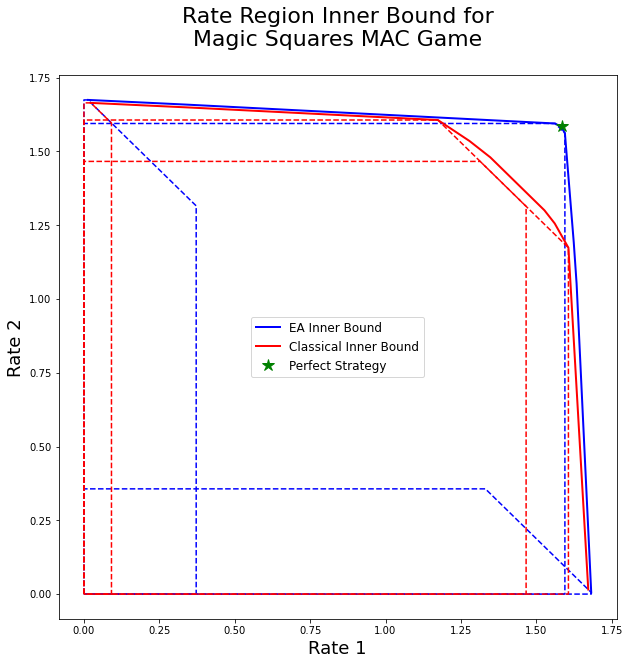

In [206]:
plt.figure(figsize=(10,10))

ea_unique_rate_tuples = np.unique(ea_opt_rate_tuples, axis=0)
for i, r_tuple in enumerate(ea_unique_rate_tuples):
    if i % 3 != 0:
        continue
    
    print("EA: extremal rate tuple : ", r_tuple)
    tuple_id = ea_rate_tuples.index(tuple(r_tuple))
    priors = ea_priors_list[tuple_id]
    
    print("EA: prior_x1 : ", priors[0].tolist())
    print("EA: prior_x2 : ", priors[1].tolist())
    
    r1_vals, r2_vals = rate_region_vertices(r_tuple)  
    plt.plot(r1_vals, r2_vals,"b--")

plt.plot(ea_R1_vals, ea_R2_vals, "b-", linewidth=2, label="EA Inner Bound")


cl_unique_rate_tuples = np.unique(cl_opt_rate_tuples, axis=0)
for i, r_tuple in enumerate(cl_unique_rate_tuples):
    if i % 3 != 0:
        continue
    
    print("CL: extremal rate tuple : ", r_tuple)
    tuple_id = cl_rate_tuples.index(tuple(r_tuple))
    priors = cl_priors_list[tuple_id]
    
    print("CL: prior_x1 : ", priors[0].tolist())
    print("CL: prior_x2 : ", priors[1].tolist())
    
    r1_vals, r2_vals = rate_region_vertices(r_tuple)  
    plt.plot(r1_vals, r2_vals,"r--")

plt.plot(cl_R1_vals, cl_R2_vals, "r-", linewidth=2, label="Classical Inner Bound")

plt.plot([np.log2(3)], [np.log2(3)], "g*", markersize=12, label="Perfect Strategy")

plt.legend(fontsize="12")

plt.xlabel("Rate 1", size=18)
plt.ylabel("Rate 2", size=18)
plt.title("Rate Region Inner Bound for\nMagic Squares MAC Game\n", size=22)
plt.show()